# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
aspect_accuracies = manager.list()
aspect_f1_micros = manager.list()
aspect_f1_macros = manager.list()
sentiment_accuracies = manager.list()
sentiment_f1_micros = manager.list()
sentiment_f1_macros = manager.list()
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()

# Non shared resources
epochs = 10
batch_size = 16
sequence_length = 48

aspect_list = ['ac', 'air_panas', 'bau', 'general', 'kebersihan', 'linen', 'service', 'sunrise_meal', 'tv', 'wifi']
aspect_mapping = {'ac': 0, 'air_panas': 1, 'bau': 2, 'general': 3, 'kebersihan': 4, 'linen': 5, 'service': 6, 'sunrise_meal': 7, 'tv': 8, 'wifi': 9}
label_mapping = {"neg": 0, "neut": 1, 'neg_pos': 1, 'pos': 2}
ignored_keys = ['labels', 'ori_text', 'ori_label', 'ori_indices', 'aspect']

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/hoasa-dataset/train_preprocess.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/hoasa-dataset/valid_preprocess.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/hoasa-dataset/test_preprocess.csv', encoding='latin-1')

data = pd.concat([train_data, val_data, test_data], ignore_index=True)

data.head()

,review,ac,air_panas,bau,general,kebersihan,linen,service,sunrise_meal,tv,wifi
0,kebersihan kurang...,neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
1,"sangat mengecewakan... hotel bad image, kebers...",neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
2,Tempat nyaman bersih tapi tv terlalu tinggi ti...,neut,neut,neut,neut,pos,neut,neut,neut,neg,neut
3,"semuanya bagus sesuai profile,dan harga promo ...",neut,neg,neut,pos,neut,neut,neut,neut,neut,neut
4,"Tempat tidur sangat keras, bantal besar dan ke...",neg,neg,neut,neut,neut,neg,neut,neut,neut,neut


In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [8]:
train_labels = train_data.columns[1:]
val_labels = val_data.columns[1:]

# Extract features and labels for training and validation
X_train = train_data['review'].values
y_train = train_data[train_labels].values
X_val = val_data['review'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2283,) (2283, 10)
(571,) (571, 10)


# BUILD DATASET & DATALOADERS

In [9]:
class AspectDetectionDataset(Dataset):
    def __init__(self, texts, labels, label_mapping, tokenizer, max_length=sequence_length, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        
        original_labels = [self.label_mapping[label] for label in self.labels[idx]]
        encoded_labels = [1 if label == 1 else 0 for label in original_labels]
        
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['ori_indices'] = idx
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(original_labels, dtype=torch.float)
        item['labels'] = torch.tensor(encoded_labels, dtype=torch.float if self.use_float else torch.long)
        
        return item

In [10]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, texts, labels, aspects, indices, label_mapping, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.aspects = aspects
        self.indices = indices
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = aspect_token + ' ' + self.aspects[idx] + ' ' + review_token + ' ' + self.texts[idx] 
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        if isinstance(self.labels[idx], str):
            self.labels[idx] = self.label_mapping[self.labels[idx]]
        elif torch.is_tensor(self.labels[idx]):
            self.labels[idx] = int(self.labels[idx].item())

        encoded_label = 1 if self.labels[idx] == 2 else self.labels[idx]
        one_hot_label = F.one_hot(torch.tensor(encoded_label, dtype=torch.long), num_classes=2).float()

        item = {key: val.squeeze() for key, val in encoding.items()}
        item['aspect'] = self.aspects[idx]
        item['labels'] = one_hot_label
        item['ori_indices'] = self.indices[idx]
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

In [11]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
review_token = '[REVIEW]'
aspect_token = '[ASPECT]'
special_tokens_dict = {'additional_special_tokens': [review_token, aspect_token]}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [12]:
def build_aspect_dataset(X_train, y_train, X_val, y_val, sequence_length, num_workers=4):
    train_dataset = AspectDetectionDataset(X_train, y_train, label_mapping, tokenizer, max_length=sequence_length)
    val_dataset = AspectDetectionDataset(X_val, y_val, label_mapping, tokenizer, max_length=sequence_length)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

In [13]:
def build_sentiment_dataset(device, train_dataset, val_dataset, aspect_detection_model, tokenizer, max_length=sequence_length):
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    aspect_detection_model.to(device)
    aspect_detection_model.eval()

    train_data = []
    train_labels = []
    train_aspects = []
    train_indices = []

    val_data = []
    val_labels = []
    val_aspects = []
    val_indices = []

    # Transform train set
    start_time = time.time()
    with torch.no_grad():
        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        train_aspects.append(aspect_list[j])
                        train_data.append(batch['ori_text'][i])
                        train_labels.append(batch['ori_label'][i][j])
                        train_indices.append(batch['ori_indices'][i])
            
        # Transform validation set
        for batch in val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        val_aspects.append(aspect_list[j])
                        val_data.append(batch['ori_text'][i])
                        val_labels.append(batch['ori_label'][i][j])
                        val_indices.append(batch['ori_indices'][i])

    train_dataset = SentimentAnalysisDataset(train_data, train_labels, train_aspects, train_indices, label_mapping, tokenizer, max_length=max_length)
    val_dataset = SentimentAnalysisDataset(val_data, val_labels, val_aspects, val_indices, label_mapping, tokenizer, max_length=max_length)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

# TRAIN THE MODEL

In [14]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 50

In [15]:
def compute_metrics(p, label, classes):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        labels=label,
        target_names=classes,
        zero_division=0
    ) 

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [16]:
def compute_metrics_overall(p, classes):
    preds = torch.tensor(p.predictions)
    labels = torch.tensor(p.label_ids)

    # Ensure it's in the correct shape
    if preds.shape != labels.shape:
        raise ValueError("Shape mismatch: predictions and labels must have the same shape.")

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Compute per-label (column-wise) precision, recall, F1
    precision_list, recall_list, f1_micro_list, f1_macro_list = [], [], [], []
    
    for i in range(labels.shape[1]):  # Loop through each column (multi-output)
        prec, rec, f1_micro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='micro', zero_division=0
        )
        _, _, f1_macro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='macro', zero_division=0
        )

        precision_list.append(prec)
        recall_list.append(rec)
        f1_micro_list.append(f1_micro)
        f1_macro_list.append(f1_macro)

    # Compute average metrics across all outputs
    precision = sum(precision_list) / len(precision_list)
    recall = sum(recall_list) / len(recall_list)
    f1_micro = sum(f1_micro_list) / len(f1_micro_list)
    f1_macro = sum(f1_macro_list) / len(f1_macro_list)

    # Generate classification report per output
    reports = [classification_report(labels[:, i], preds[:, i], target_names=classes, zero_division=0) for i in range(labels.shape[1])]

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'reports': reports  # Returns list of reports, one for each output label
    }


In [17]:
def train_model(current_train_size, train_indices, aspect_metrics, sentiment_metrics, metrics, trials, seed, filename):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    aspect_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=len(train_labels),
        problem_type="multi_label_classification"
    )

    # Freeze the first few layers of the encoder
    for name, param in aspect_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define optimizer and loss function
    aspect_optimizer = torch.optim.AdamW(aspect_model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    aspect_train_loader, aspect_val_loader, aspect_train_dataset, aspect_val_dataset = build_aspect_dataset(current_X_train, current_y_train, X_val, y_val, sequence_length)

    # Prepare everything with Accelerator
    aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader = accelerator.prepare(
        aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader
    )

    nearest_cp = current_train_size
    if nearest_cp not in checkpoints:
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
    percentage = math.ceil(nearest_cp / total_data * 100)

    aspect_result = None
    start_time = time.time()

    # ASPECT DETECTION
    accelerator.print("ASPECT DETECTION")
    for epoch in range(epochs):
        aspect_model.train()
        epoch_loss = 0

        for batch in aspect_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            aspect_optimizer.zero_grad()
            outputs = aspect_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            aspect_optimizer.step()
        
            epoch_loss += loss.item()
            
        aspect_model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in aspect_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                labels = batch['labels']
                
                outputs = aspect_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}),
            None,
            aspect_list,
        )

        if aspect_result is None or result['f1_micro'] >= aspect_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(aspect_model)
            unwrapped_model.save_pretrained(
                f'{filename}-aspect-{trials + 1}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            aspect_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(aspect_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"\nAspect detection accuracy: {round(aspect_result['accuracy'], 4)}, F1 Micro: {round(aspect_result['f1_micro'], 4)}, F1 Macro: {round(aspect_result['f1_macro'], 4)}")
    accelerator.print(aspect_result['report'])

    best_aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{trials + 1}-model-{percentage}')
    best_aspect_model = accelerator.prepare(best_aspect_model)

    # SENTIMENT ANALYSIS ON NON NEUTRAL ASPECTS
    accelerator.print("--------------------------------------------------")
    accelerator.print("SENTIMENT ANALYSIS")

    sentiment_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=2,
    )
    sentiment_optimizer = torch.optim.AdamW(sentiment_model.parameters(), lr=2e-5, weight_decay=0.01)

    for name, param in sentiment_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    accelerator.wait_for_everyone()
    sentiment_train_loader, sentiment_val_loader, sentiment_train_dataset, sentiment_val_dataset = build_sentiment_dataset(
        device, aspect_train_dataset, aspect_val_dataset, best_aspect_model, tokenizer, max_length=sequence_length
    )
    sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader = accelerator.prepare(
        sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader
    )
    sentiment_result = None

    for epoch in range(epochs):
        sentiment_model.train()
        epoch_loss = 0
        
        for batch in sentiment_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            sentiment_optimizer.zero_grad()
            outputs = sentiment_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            sentiment_optimizer.step()
        
            epoch_loss += loss.item()

        sentiment_model.eval()
        sentiment_val_outputs = []
        
        with torch.no_grad():
            for batch in sentiment_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                
                outputs = sentiment_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                for i in range(len(preds)):
                    val_output = {
                        'label': batch['labels'][i],
                        'aspect': batch['aspect'][i],
                        'ori_indices': batch['ori_indices'][i],
                        'pred': np.argmax(preds[i].cpu().numpy()),
                    }
                    sentiment_val_outputs.append(val_output)

        sentiment_val_outputs = accelerator.gather_for_metrics(sentiment_val_outputs)
        unique_val_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_val_outputs}
        sentiment_val_outputs = list(unique_val_outputs.values())

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': [item['pred'] for item in sentiment_val_outputs], 'label_ids': [np.argmax(item['label'].cpu().numpy()) for item in sentiment_val_outputs]}),
            [0, 1],
            ['negative', 'positive']
        )

        if sentiment_result is None or result['f1_micro'] >= sentiment_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            sentiment_result = result
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(sentiment_model)
            unwrapped_model.save_pretrained(
                 f'{filename}-sentiment-{trials + 1}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(sentiment_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
    
    end_time = time.time()
    duration = end_time - start_time

    accelerator.print(f"\nSentiment analysis accuracy: {round(sentiment_result['accuracy'], 4)}, F1 Micro: {round(sentiment_result['f1_micro'], 4)}, F1 Macro: {round(sentiment_result['f1_macro'], 4)}")
    accelerator.print(sentiment_result['report'])

    accelerator.wait_for_everyone()
    best_sentiment_model = BertForSequenceClassification.from_pretrained( f'{filename}-sentiment-{trials + 1}-model-{percentage}')
    best_sentiment_model = accelerator.prepare(best_sentiment_model)

    # Compute overall metrics
    aspect_labels = []
    aspect_indices = []
    aspect_preds = []

    aspect_outputs = {}
    sentiment_outputs = []
    
    best_aspect_model.eval()
    best_sentiment_model.eval()

    with torch.no_grad():
        for batch in aspect_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_aspect_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            aspect_indices.append(accelerator.gather(batch['ori_indices']))
            aspect_labels.append(accelerator.gather(batch['ori_label']))
            aspect_preds.append(accelerator.gather(preds))

        aspect_indices = torch.cat(aspect_indices).cpu().numpy()
        aspect_labels = torch.cat(aspect_labels).cpu().numpy()
        aspect_preds = torch.cat(aspect_preds).cpu().numpy()

        accelerator.wait_for_everyone()
        aspect_outputs = [
            {'ori_indices': aspect_indices[i], 
             'ori_labels': aspect_labels[i], 
             'pred': aspect_preds[i]}
            for i in range(len(aspect_preds))
        ]
        aspect_outputs = {x['ori_indices'].item(): x for x in aspect_outputs}
    
        for batch in sentiment_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_sentiment_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()
    
            for i in range(len(preds)):
                output = {
                    'aspect': batch['aspect'][i],
                    'ori_indices': batch['ori_indices'][i],
                    'pred': np.argmax(preds[i].cpu().numpy()),
                }
                sentiment_outputs.append(output)

        sentiment_outputs = accelerator.gather_for_metrics(sentiment_outputs)
        sentiment_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_outputs}

    # Replcae non neutral aspect to its predicted sentiment
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        i = -1
        for (ori_index, aspect), value in sentiment_outputs.items():
            aspect = aspect_mapping[aspect]
            aspect_outputs[ori_index]['pred'][aspect] = 2 if value['pred'] == 1.0 else value['pred']

        result = compute_metrics_overall(
            type('EvalOutput', (object,), {'predictions': [output['pred'] for output in aspect_outputs.values()], 'label_ids': [output['ori_labels'] for output in aspect_outputs.values()]}),
            ['negative', 'neutral', 'positive'],
        )

        accelerator.print("--------------------------------------------------")
        accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
        accelerator.print("--------------------------------------------------")
        for i in range(len(train_labels)):
            accelerator.print(f"Aspect {aspect_list[i]} report:")
            accelerator.print(result['reports'][i])
       
        
        aspect_metrics[0].append(aspect_result['accuracy'])
        aspect_metrics[1].append(aspect_result['f1_micro'])
        aspect_metrics[2].append(aspect_result['f1_macro'])
        sentiment_metrics[0].append(sentiment_result['accuracy'])
        sentiment_metrics[1].append(sentiment_result['f1_micro'])
        sentiment_metrics[2].append(sentiment_result['f1_macro'])
        metrics[0].append(current_train_size)
        metrics[1].append(result['accuracy'])
        metrics[2].append(result['f1_micro'])
        metrics[3].append(result['f1_macro'])
        
    accelerator.print(f"Total train time: {duration} s")
    accelerator.end_training()
    return

# PLOT THE RESULTS

In [18]:
def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [19]:
def kmeans_clustering_sampling(aspect_model, sentiment_model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, filename, n_clusters=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    aspect_model.to(device)
    aspect_model.eval()
    sentiment_model.to(device)
    sentiment_model.eval()

    current_train_size = len(train_indices)
    aspect_dataset = AspectDetectionDataset(
        X_pool, 
        [['neut' for i in range(len(train_labels))] for x in range(len(X_pool))], 
        label_mapping, 
        tokenizer, 
        max_length=sequence_length
    )
    aspect_loader = DataLoader(
        aspect_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )
    
    aspect_outputs = {}
    sentiment_outputs = {}

    aspects = []
    data = []
    labels = []
    indices = []

    start_time = time.time()

    # Pass through aspect detction model
    for batch in aspect_loader:
        token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        
        with torch.no_grad():
            outputs = aspect_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids).logits
            embeddings = aspect_model.base_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        for i in range(len(outputs)):
            aspect_outputs[batch['ori_indices'][i].item()] = embeddings.last_hidden_state[i].mean(dim=1).cpu().numpy()
            
            for j in range(len(outputs[i])):
                if int(outputs[i][j].round()) != 1:
                    aspects.append(aspect_list[j])
                    data.append(batch['ori_text'][i])
                    labels.append(batch['ori_label'][i][j])
                    indices.append(batch['ori_indices'][i])

    if len(data) > 0:
        sentiment_dataset = SentimentAnalysisDataset(data, labels, aspects, indices, label_mapping, tokenizer, max_length=sequence_length)
        sentiment_loader = torch.utils.data.DataLoader(
            sentiment_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4,
        )
    
        # Pass through sentiment analysis model
        for batch in sentiment_loader:
            token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)
    
            with torch.no_grad():
                outputs = sentiment_model.base_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    
            for i in range(len(outputs.last_hidden_state)):
                ori_index = batch['ori_indices'][i].item()
                if ori_index in sentiment_outputs.keys():
                    sentiment_outputs[ori_index].append(outputs.last_hidden_state[i].mean(dim=1).cpu().numpy())
                else:
                    sentiment_outputs[ori_index] = [outputs.last_hidden_state[i].mean(dim=1).cpu().numpy()]

    for key, val in sentiment_outputs.items():
        sentiment_outputs[key] = np.mean(val, axis=0)

    collected_indices = set()  # Initialize set to store selected indices
    thresholds = []

    if accelerator.is_main_process:
        aspect_outputs = dict(sorted(aspect_outputs.items()))

        if len(data) > 0:
            for key, val in sentiment_outputs.items():
                aspect_outputs[key] = np.mean([val, aspect_outputs[key]], axis=0)

        embeddings = np.array(list(aspect_outputs.values()))
        target_samples = len(embeddings[:math.ceil(0.1 * len(embeddings))])
    
        # Check nearest checkpoint
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
                
        # Determine number of maximum samples to be acquired
        if target_samples <= n_clusters and n_clusters < nearest_cp - current_train_size:
            target_samples = n_clusters
        elif target_samples > n_clusters and target_samples < nearest_cp - current_train_size:
            target_samples = target_samples
        else:
            arrived_at_cp = True
            target_samples = nearest_cp - current_train_size

        # No clustering needed when there's little data left
        if current_train_size >= checkpoints[len(checkpoints)-1] - min_increment:
            end_time = time.time()
            duration = end_time - start_time
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'ac': [y_train[i][0] for i in temp],
                'air_panas': [y_train[i][1] for i in temp],
                'bau': [y_train[i][2] for i in temp],
                'general': [y_train[i][3] for i in temp],
                'kebersihan': [y_train[i][4] for i in temp],
                'linen': [y_train[i][5] for i in temp],
                'service': [y_train[i][6] for i in temp],
                'sunrise_meal': [y_train[i][7] for i in temp],
                'tv': [y_train[i][8] for i in temp],
                'wifi': [y_train[i][9] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in remaining_indices:
                new_samples.append(i)
        else:
            # Cluster the data based on its embeddings
            kmeans=KMeans(n_clusters=n_clusters, n_init=1)
            kmeans.fit(embeddings)
            
            for cluster_id in range(n_clusters):
                # Cluster center and indices of samples in the current cluster
                cluster_center = kmeans.cluster_centers_[cluster_id]
                cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
            
                if cluster_indices.size == 0:
                    # Skip clusters with no members
                    print(f"Cluster {cluster_id} has no members, skipping.")
                    continue
            
                # Calculate distances of each point in the cluster from the cluster center
                cluster_distances = np.linalg.norm(embeddings[cluster_indices] - cluster_center, axis=1)
            
                # Determine the local threshold (10th percentile of closest distances to cluster center)
                local_threshold = np.percentile(cluster_distances, 90)
                thresholds.append(local_threshold)
            
                below_threshold_indices = cluster_indices[cluster_distances >= local_threshold]
                collected_indices.update(below_threshold_indices)

            # To handle multiple points with same distance
            if len(collected_indices) > target_samples:
                collected_indices = np.array(list(collected_indices))
                np.random.shuffle(collected_indices)
                collected_indices = collected_indices[:target_samples]
                
            end_time = time.time() 
            duration = end_time - start_time 
    
            if arrived_at_cp:
                temp = train_indices.copy()
                temp.extend(collected_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'ac': [y_train[i][0] for i in temp],
                    'air_panas': [y_train[i][1] for i in temp],
                    'bau': [y_train[i][2] for i in temp],
                    'general': [y_train[i][3] for i in temp],
                    'kebersihan': [y_train[i][4] for i in temp],
                    'linen': [y_train[i][5] for i in temp],
                    'service': [y_train[i][6] for i in temp],
                    'sunrise_meal': [y_train[i][7] for i in temp],
                    'tv': [y_train[i][8] for i in temp],
                    'wifi': [y_train[i][9] for i in temp],
                })
        
                acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(collected_indices))
            print(f"Sampling duration: {duration} seconds")
        
            sampling_dur.append(duration)
            for i in collected_indices:
                new_samples.append(remaining_indices[i])

        threshold_data = pd.DataFrame({
            'Threshold': thresholds
        })
        threshold_data.to_csv(f"results/{filename}-thresholds-{trials+1}-{current_train_size}.csv", index=False)

# MAIN LOOP

In [20]:
def active_learning(seed, i, init_size):
    aspect_accuracies = manager.list()
    aspect_f1_micros = manager.list()
    aspect_f1_macros = manager.list()
    sentiment_accuracies = manager.list()
    sentiment_f1_micros = manager.list()
    sentiment_f1_macros = manager.list()
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    filename = f'hoasa-kmeans-init-{init_size}'

    set_seed(seed)
    
    print("===============================================")
    print("Init Size {}".format(init_size))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (
            current_train_size, 
            train_indices, 
            (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
            (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
            (data_used, accuracies, f1_micros, f1_macros), 
            i,
            seed,
            filename
        )
        notebook_launcher(train_model, args, num_processes=2)

        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)

        aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{i+1}-model-{percentage}')
        sentiment_model = BertForSequenceClassification.from_pretrained(f'{filename}-sentiment-{i+1}-model-{percentage}')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (
            aspect_model, 
            sentiment_model, 
            [X_train[i] for i in remaining_indices], 
            train_indices, 
            remaining_indices, 
            sampling_dur, 
            new_samples, 
            i,
            filename
        )
        notebook_launcher(kmeans_clustering_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (
        current_train_size, 
        train_indices, 
        (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
        (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
        (data_used, accuracies, f1_micros, f1_macros), 
        i,
        seed,
        filename
    )
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    # print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Aspect Accuracy': aspect_accuracies,
        'Aspect F1 Micro': aspect_f1_micros,
        'Aspect F1 Macro': aspect_f1_macros,
        'Sentiment Accuracy': sentiment_accuracies,
        'Sentiment F1 Micro': sentiment_f1_micros,
        'Sentiment F1 Macro': sentiment_f1_macros,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

Init Size 1
Random seed: 81
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7629, Accuracy: 0.4733, F1 Micro: 0.5873, F1 Macro: 0.491
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.7254, Accuracy: 0.5719, F1 Micro: 0.6993, F1 Macro: 0.6035
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.6779, Accuracy: 0.6304, F1 Micro: 0.7608, F1 Macro: 0.6848
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.616, Accuracy: 0.6764, F1 Micro: 0.8005, F1 Macro: 0.756
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.5873, Accuracy: 0.7193, F1 Micro: 0.8328, F1 Macro: 0.8117
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.5466, Accuracy: 0.7545, F1 Micro: 0.8574, F1 Macro: 0.8462
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.5374, Accuracy: 0.7812, F1 Micro: 0.8753, F1 Macro: 0.868
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4948, Accuracy: 0.7958, F1 Micro: 0.8848, F1 Macro: 0.8769
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7093, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6098, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5463, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4848, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4943, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4027, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3762, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4164, Accuracy: 0.3975, F1 Micro: 0.3975, F1 Macro: 0.2844
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6358, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8851
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4822, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4522, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4396, Accuracy: 0.8024, F1 Micro: 0.8902, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.415, Accuracy: 0.8092, F1 Micro: 0.8934, F1 Macro: 0.8885
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3809, Accuracy: 0.8286, F1 Micro: 0.902, F1 Macro: 0.8948
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.358, Accuracy: 0.8408, F1 Micro: 0.9075, F1 Macro: 0.8997
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3305, Accuracy: 0.8556, F1 Micro: 0.9157, F1 Macro: 0.9097
Higher F1 achieved, saving model
Epoch 9/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.513, Accuracy: 0.7277, F1 Micro: 0.7277, F1 Macro: 0.4212
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5117, Accuracy: 0.7277, F1 Micro: 0.7277, F1 Macro: 0.4212
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3459, Accuracy: 0.7731, F1 Micro: 0.7731, F1 Macro: 0.6441
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3251, Accuracy: 0.8098, F1 Micro: 0.8098, F1 Macro: 0.749
Epoch 5/10, Train Loss: 0.2253, Accuracy: 0.7906, F1 Micro: 0.7906, F1 Macro: 0.6736
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2657, Accuracy: 0.815, F1 Micro: 0.815, F1 Macro: 0.7257
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2199, Accuracy: 0.8185, F1 Micro: 0.8185, F1 Macro: 0.734
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1602, Accuracy: 0.8255, F1 Micro: 0.8255, F1 Macro: 0.7577
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1326, Accuracy: 0.8255, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5728, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4675, Accuracy: 0.8014, F1 Micro: 0.8897, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4493, Accuracy: 0.8288, F1 Micro: 0.9024, F1 Macro: 0.8964
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.41, Accuracy: 0.8417, F1 Micro: 0.9087, F1 Macro: 0.9034
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3506, Accuracy: 0.8797, F1 Micro: 0.929, F1 Macro: 0.9244
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2874, Accuracy: 0.9054, F1 Micro: 0.943, F1 Macro: 0.9387
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2587, Accuracy: 0.913, F1 Micro: 0.9473, F1 Macro: 0.9431
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2207, Accuracy: 0.9262, F1 Micro: 0.9549, F1 Macro: 0.9512
Higher F1 achieved, saving model
Epoch 9/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5647, Accuracy: 0.729, F1 Micro: 0.729, F1 Macro: 0.4331
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3882, Accuracy: 0.7727, F1 Micro: 0.7727, F1 Macro: 0.7355
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3025, Accuracy: 0.8, F1 Micro: 0.8, F1 Macro: 0.6641
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2276, Accuracy: 0.8415, F1 Micro: 0.8415, F1 Macro: 0.7847
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2274, Accuracy: 0.8546, F1 Micro: 0.8546, F1 Macro: 0.7928
Epoch 6/10, Train Loss: 0.1738, Accuracy: 0.8525, F1 Micro: 0.8525, F1 Macro: 0.786
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1581, Accuracy: 0.8634, F1 Micro: 0.8634, F1 Macro: 0.8065
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1114, Accuracy: 0.8656, F1 Micro: 0.8656, F1 Macro: 0.8109
Epoch 9/10, Train Loss: 0.0924, Accuracy: 0.8601, F1 Micro: 0.8601, F1 Macro: 0.7952
Higher F1 ach

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5604, Accuracy: 0.8012, F1 Micro: 0.8896, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4717, Accuracy: 0.8208, F1 Micro: 0.8981, F1 Macro: 0.8914
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4335, Accuracy: 0.8351, F1 Micro: 0.9059, F1 Macro: 0.9014
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3692, Accuracy: 0.8854, F1 Micro: 0.9317, F1 Macro: 0.9258
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3032, Accuracy: 0.9156, F1 Micro: 0.9485, F1 Macro: 0.9434
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2683, Accuracy: 0.93, F1 Micro: 0.9572, F1 Macro: 0.9531
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2279, Accuracy: 0.93, F1 Micro: 0.9574, F1 Macro: 0.9542
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1862, Accuracy: 0.9418, F1 Micro: 0.9643, F1 Macro: 0.9612
Epoch 9/10, Train Loss: 0.1757, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.515, Accuracy: 0.7915, F1 Micro: 0.7915, F1 Macro: 0.6896
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3642, Accuracy: 0.8087, F1 Micro: 0.8087, F1 Macro: 0.6797
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2935, Accuracy: 0.8674, F1 Micro: 0.8674, F1 Macro: 0.8185
Epoch 4/10, Train Loss: 0.2359, Accuracy: 0.8654, F1 Micro: 0.8654, F1 Macro: 0.8303
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1795, Accuracy: 0.8836, F1 Micro: 0.8836, F1 Macro: 0.8378
Epoch 6/10, Train Loss: 0.1344, Accuracy: 0.8725, F1 Micro: 0.8725, F1 Macro: 0.829
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0974, Accuracy: 0.8968, F1 Micro: 0.8968, F1 Macro: 0.8601
Epoch 8/10, Train Loss: 0.0552, Accuracy: 0.8957, F1 Micro: 0.8957, F1 Macro: 0.8589
Epoch 9/10, Train Loss: 0.0566, Accuracy: 0.8937, F1 Micro: 0.8937, F1 Macro: 0.8545
Epoch 10/10, Train Loss: 0.07, Accuracy: 0.8927, F1 Micro: 0.8927, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5451, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4683, Accuracy: 0.8271, F1 Micro: 0.9018, F1 Macro: 0.897
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4024, Accuracy: 0.8741, F1 Micro: 0.9257, F1 Macro: 0.9195
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3129, Accuracy: 0.9146, F1 Micro: 0.9483, F1 Macro: 0.944
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2524, Accuracy: 0.9347, F1 Micro: 0.9599, F1 Macro: 0.9561
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.214, Accuracy: 0.9413, F1 Micro: 0.9638, F1 Macro: 0.9595
Epoch 7/10, Train Loss: 0.1808, Accuracy: 0.9398, F1 Micro: 0.9632, F1 Macro: 0.9604
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1584, Accuracy: 0.946, F1 Micro: 0.9667, F1 Macro: 0.9633
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1411, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4832, Accuracy: 0.8173, F1 Micro: 0.8173, F1 Macro: 0.7297
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.326, Accuracy: 0.8462, F1 Micro: 0.8462, F1 Macro: 0.7827
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.252, Accuracy: 0.8654, F1 Micro: 0.8654, F1 Macro: 0.8266
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2031, Accuracy: 0.8798, F1 Micro: 0.8798, F1 Macro: 0.8474
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1516, Accuracy: 0.8875, F1 Micro: 0.8875, F1 Macro: 0.8606
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1332, Accuracy: 0.8894, F1 Micro: 0.8894, F1 Macro: 0.8597
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1019, Accuracy: 0.899, F1 Micro: 0.899, F1 Macro: 0.8735
Epoch 8/10, Train Loss: 0.076, Accuracy: 0.8856, F1 Micro: 0.8856, F1 Macro: 0.8564
Epoch 9/10, Train Loss: 0.0478, Accuracy: 0.8942, F1 Micro: 0.8942, F1 Macro: 0.8621
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5295, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4483, Accuracy: 0.8391, F1 Micro: 0.9079, F1 Macro: 0.9025
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3586, Accuracy: 0.9033, F1 Micro: 0.9422, F1 Macro: 0.938
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2782, Accuracy: 0.9283, F1 Micro: 0.9564, F1 Macro: 0.9531
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.23, Accuracy: 0.9434, F1 Micro: 0.9653, F1 Macro: 0.9622
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1961, Accuracy: 0.9476, F1 Micro: 0.9678, F1 Macro: 0.9652
Epoch 7/10, Train Loss: 0.1637, Accuracy: 0.9472, F1 Micro: 0.9675, F1 Macro: 0.9647
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1446, Accuracy: 0.949, F1 Micro: 0.9686, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1211, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4796, Accuracy: 0.8295, F1 Micro: 0.8295, F1 Macro: 0.7677
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.321, Accuracy: 0.8672, F1 Micro: 0.8672, F1 Macro: 0.8276
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2432, Accuracy: 0.8934, F1 Micro: 0.8934, F1 Macro: 0.8586
Epoch 4/10, Train Loss: 0.2015, Accuracy: 0.8886, F1 Micro: 0.8886, F1 Macro: 0.8455
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1347, Accuracy: 0.905, F1 Micro: 0.905, F1 Macro: 0.874
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0907, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.8774
Epoch 7/10, Train Loss: 0.0789, Accuracy: 0.9021, F1 Micro: 0.9021, F1 Macro: 0.8744
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0623, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.8774
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0621, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.8774
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5308, Accuracy: 0.8042, F1 Micro: 0.8909, F1 Macro: 0.8862
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4371, Accuracy: 0.862, F1 Micro: 0.9194, F1 Macro: 0.9126
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3394, Accuracy: 0.9132, F1 Micro: 0.9475, F1 Macro: 0.9433
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2609, Accuracy: 0.9359, F1 Micro: 0.961, F1 Macro: 0.9587
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2124, Accuracy: 0.9432, F1 Micro: 0.9653, F1 Macro: 0.9629
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.189, Accuracy: 0.95, F1 Micro: 0.9692, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1579, Accuracy: 0.9514, F1 Micro: 0.9701, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1329, Accuracy: 0.9543, F1 Micro: 0.9718, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4845, Accuracy: 0.8387, F1 Micro: 0.8387, F1 Macro: 0.7948
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3324, Accuracy: 0.8521, F1 Micro: 0.8521, F1 Macro: 0.8151
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2747, Accuracy: 0.8855, F1 Micro: 0.8855, F1 Macro: 0.8503
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1766, Accuracy: 0.8903, F1 Micro: 0.8903, F1 Macro: 0.8557
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1365, Accuracy: 0.8912, F1 Micro: 0.8912, F1 Macro: 0.8535
Epoch 6/10, Train Loss: 0.1112, Accuracy: 0.8884, F1 Micro: 0.8884, F1 Macro: 0.8478
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0695, Accuracy: 0.896, F1 Micro: 0.896, F1 Macro: 0.8615
Epoch 8/10, Train Loss: 0.0461, Accuracy: 0.8884, F1 Micro: 0.8884, F1 Macro: 0.849
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0631, Accuracy: 0.9017, F1 Micro: 0.9017, F1 Macro: 0.8704
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5187, Accuracy: 0.8092, F1 Micro: 0.8931, F1 Macro: 0.8877
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4215, Accuracy: 0.8873, F1 Micro: 0.9332, F1 Macro: 0.9282
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3151, Accuracy: 0.9274, F1 Micro: 0.956, F1 Macro: 0.9528
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.242, Accuracy: 0.9436, F1 Micro: 0.9655, F1 Macro: 0.9629
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1929, Accuracy: 0.9486, F1 Micro: 0.9685, F1 Macro: 0.9657
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.177, Accuracy: 0.9502, F1 Micro: 0.9694, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1416, Accuracy: 0.9547, F1 Micro: 0.9721, F1 Macro: 0.9699
Epoch 8/10, Train Loss: 0.1226, Accuracy: 0.9538, F1 Micro: 0.9716, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1064, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4581, Accuracy: 0.8237, F1 Micro: 0.8237, F1 Macro: 0.7329
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3136, Accuracy: 0.8607, F1 Micro: 0.8607, F1 Macro: 0.8155
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2336, Accuracy: 0.8749, F1 Micro: 0.8749, F1 Macro: 0.8256
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.201, Accuracy: 0.8872, F1 Micro: 0.8872, F1 Macro: 0.8464
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1384, Accuracy: 0.8929, F1 Micro: 0.8929, F1 Macro: 0.8567
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0984, Accuracy: 0.8929, F1 Micro: 0.8929, F1 Macro: 0.8537
Epoch 7/10, Train Loss: 0.0858, Accuracy: 0.891, F1 Micro: 0.891, F1 Macro: 0.8507
Epoch 8/10, Train Loss: 0.0762, Accuracy: 0.8891, F1 Micro: 0.8891, F1 Macro: 0.8542
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0507, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.8707
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5174, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3967, Accuracy: 0.8925, F1 Micro: 0.9361, F1 Macro: 0.9316
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2806, Accuracy: 0.9363, F1 Micro: 0.9611, F1 Macro: 0.9585
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2237, Accuracy: 0.9413, F1 Micro: 0.9641, F1 Macro: 0.9618
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1881, Accuracy: 0.9479, F1 Micro: 0.9681, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1593, Accuracy: 0.953, F1 Micro: 0.971, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1355, Accuracy: 0.9597, F1 Micro: 0.975, F1 Macro: 0.9728
Epoch 8/10, Train Loss: 0.1127, Accuracy: 0.9573, F1 Micro: 0.9736, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0985, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4402, Accuracy: 0.8448, F1 Micro: 0.8448, F1 Macro: 0.7912
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2969, Accuracy: 0.876, F1 Micro: 0.876, F1 Macro: 0.8436
Epoch 3/10, Train Loss: 0.218, Accuracy: 0.8751, F1 Micro: 0.8751, F1 Macro: 0.8264
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1524, Accuracy: 0.8981, F1 Micro: 0.8981, F1 Macro: 0.8658
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1019, Accuracy: 0.9008, F1 Micro: 0.9008, F1 Macro: 0.8711
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0827, Accuracy: 0.9017, F1 Micro: 0.9017, F1 Macro: 0.8718
Epoch 7/10, Train Loss: 0.0729, Accuracy: 0.8944, F1 Micro: 0.8944, F1 Macro: 0.8638
Epoch 8/10, Train Loss: 0.0612, Accuracy: 0.899, F1 Micro: 0.899, F1 Macro: 0.8669
Epoch 9/10, Train Loss: 0.0442, Accuracy: 0.9008, F1 Micro: 0.9008, F1 Macro: 0.8699
Epoch 10/10, Train Loss: 0.0317, Accuracy: 0.8981, F1 Micro: 0.8981, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5102, Accuracy: 0.8113, F1 Micro: 0.8944, F1 Macro: 0.89
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3905, Accuracy: 0.9003, F1 Micro: 0.9396, F1 Macro: 0.9325
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2799, Accuracy: 0.9399, F1 Micro: 0.9632, F1 Macro: 0.9608
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2154, Accuracy: 0.9469, F1 Micro: 0.9674, F1 Macro: 0.9653
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1799, Accuracy: 0.9521, F1 Micro: 0.9704, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1472, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9735
Epoch 7/10, Train Loss: 0.1265, Accuracy: 0.9575, F1 Micro: 0.9738, F1 Macro: 0.9711
Epoch 8/10, Train Loss: 0.1062, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9728
Epoch 9/10, Train Loss: 0.0939, Accuracy: 0.9578, F1 Micro: 0.9739, F1 Macro: 0.9716
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.452, Accuracy: 0.8488, F1 Micro: 0.8488, F1 Macro: 0.7972
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2971, Accuracy: 0.8726, F1 Micro: 0.8726, F1 Macro: 0.8328
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2235, Accuracy: 0.8863, F1 Micro: 0.8863, F1 Macro: 0.8534
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1924, Accuracy: 0.8928, F1 Micro: 0.8928, F1 Macro: 0.8593
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.157, Accuracy: 0.8955, F1 Micro: 0.8955, F1 Macro: 0.8687
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1098, Accuracy: 0.901, F1 Micro: 0.901, F1 Macro: 0.8721
Epoch 7/10, Train Loss: 0.1002, Accuracy: 0.9001, F1 Micro: 0.9001, F1 Macro: 0.8692
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0756, Accuracy: 0.9019, F1 Micro: 0.9019, F1 Macro: 0.8725
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0478, Accuracy: 0.9047, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5077, Accuracy: 0.8108, F1 Micro: 0.8927, F1 Macro: 0.8839
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3838, Accuracy: 0.9069, F1 Micro: 0.9441, F1 Macro: 0.9397
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2699, Accuracy: 0.9337, F1 Micro: 0.9596, F1 Macro: 0.9564
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2217, Accuracy: 0.9495, F1 Micro: 0.9688, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1806, Accuracy: 0.9521, F1 Micro: 0.9705, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1502, Accuracy: 0.9578, F1 Micro: 0.974, F1 Macro: 0.972
Epoch 7/10, Train Loss: 0.1298, Accuracy: 0.9569, F1 Micro: 0.9734, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.106, Accuracy: 0.9597, F1 Micro: 0.9751, F1 Macro: 0.9729
Epoch 9/10, Train Loss: 0.0936, Accuracy: 0.9599, F1 Micro: 0.9751, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4399, Accuracy: 0.857, F1 Micro: 0.857, F1 Macro: 0.8146
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2473, Accuracy: 0.8793, F1 Micro: 0.8793, F1 Macro: 0.8398
Epoch 3/10, Train Loss: 0.1781, Accuracy: 0.87, F1 Micro: 0.87, F1 Macro: 0.8182
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1633, Accuracy: 0.8923, F1 Micro: 0.8923, F1 Macro: 0.8559
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1127, Accuracy: 0.909, F1 Micro: 0.909, F1 Macro: 0.8836
Epoch 6/10, Train Loss: 0.0755, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.878
Epoch 7/10, Train Loss: 0.0445, Accuracy: 0.8988, F1 Micro: 0.8988, F1 Macro: 0.8661
Epoch 8/10, Train Loss: 0.0501, Accuracy: 0.9016, F1 Micro: 0.9016, F1 Macro: 0.8709
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0389, Accuracy: 0.909, F1 Micro: 0.909, F1 Macro: 0.8834
Epoch 10/10, Train Loss: 0.0347, Accuracy: 0.9034, F1 Micro: 0.9034, F1 Macro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5065, Accuracy: 0.8224, F1 Micro: 0.8991, F1 Macro: 0.8924
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3648, Accuracy: 0.916, F1 Micro: 0.949, F1 Macro: 0.9451
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2626, Accuracy: 0.9387, F1 Micro: 0.9625, F1 Macro: 0.9598
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2037, Accuracy: 0.9462, F1 Micro: 0.967, F1 Macro: 0.9646
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1753, Accuracy: 0.9543, F1 Micro: 0.9719, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1414, Accuracy: 0.9578, F1 Micro: 0.9739, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1206, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9735
Epoch 8/10, Train Loss: 0.1012, Accuracy: 0.9602, F1 Micro: 0.9753, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0898, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4288, Accuracy: 0.8498, F1 Micro: 0.8498, F1 Macro: 0.8046
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2603, Accuracy: 0.8759, F1 Micro: 0.8759, F1 Macro: 0.8361
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1897, Accuracy: 0.893, F1 Micro: 0.893, F1 Macro: 0.8623
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.157, Accuracy: 0.893, F1 Micro: 0.893, F1 Macro: 0.8671
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1057, Accuracy: 0.9029, F1 Micro: 0.9029, F1 Macro: 0.8773
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0847, Accuracy: 0.9056, F1 Micro: 0.9056, F1 Macro: 0.879
Epoch 7/10, Train Loss: 0.0699, Accuracy: 0.8993, F1 Micro: 0.8993, F1 Macro: 0.8716
Epoch 8/10, Train Loss: 0.0483, Accuracy: 0.8993, F1 Micro: 0.8993, F1 Macro: 0.8708
Epoch 9/10, Train Loss: 0.0319, Accuracy: 0.902, F1 Micro: 0.902, F1 Macro: 0.8765
Epoch 10/10, Train Loss: 0.0326, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4963, Accuracy: 0.8243, F1 Micro: 0.8991, F1 Macro: 0.889
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3593, Accuracy: 0.9187, F1 Micro: 0.9509, F1 Macro: 0.9471
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2516, Accuracy: 0.9396, F1 Micro: 0.9631, F1 Macro: 0.9607
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1994, Accuracy: 0.9507, F1 Micro: 0.9698, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1614, Accuracy: 0.9556, F1 Micro: 0.9726, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1394, Accuracy: 0.9602, F1 Micro: 0.9753, F1 Macro: 0.9732
Epoch 7/10, Train Loss: 0.1154, Accuracy: 0.9597, F1 Micro: 0.975, F1 Macro: 0.9725
Epoch 8/10, Train Loss: 0.0981, Accuracy: 0.9594, F1 Micro: 0.9748, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0856, Accuracy: 0.9632, F1 Micro: 0.9771, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4373, Accuracy: 0.8459, F1 Micro: 0.8459, F1 Macro: 0.791
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.252, Accuracy: 0.8821, F1 Micro: 0.8821, F1 Macro: 0.8466
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1575, Accuracy: 0.8994, F1 Micro: 0.8994, F1 Macro: 0.8731
Epoch 4/10, Train Loss: 0.1229, Accuracy: 0.8957, F1 Micro: 0.8957, F1 Macro: 0.8679
Epoch 5/10, Train Loss: 0.0814, Accuracy: 0.8985, F1 Micro: 0.8985, F1 Macro: 0.8736
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0705, Accuracy: 0.9012, F1 Micro: 0.9012, F1 Macro: 0.8746
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0552, Accuracy: 0.9039, F1 Micro: 0.9039, F1 Macro: 0.8774
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0398, Accuracy: 0.9039, F1 Micro: 0.9039, F1 Macro: 0.8774
Epoch 9/10, Train Loss: 0.0341, Accuracy: 0.9003, F1 Micro: 0.9003, F1 Macro: 0.8749
Epoch 10/10, Train Loss: 0.0246, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4989, Accuracy: 0.8262, F1 Micro: 0.9018, F1 Macro: 0.8973
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3494, Accuracy: 0.9224, F1 Micro: 0.953, F1 Macro: 0.95
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.239, Accuracy: 0.938, F1 Micro: 0.9622, F1 Macro: 0.96
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1905, Accuracy: 0.9521, F1 Micro: 0.9705, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1641, Accuracy: 0.9576, F1 Micro: 0.9739, F1 Macro: 0.9717
Epoch 6/10, Train Loss: 0.1331, Accuracy: 0.9573, F1 Micro: 0.9736, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.114, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9739
Epoch 8/10, Train Loss: 0.0986, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0832, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4037, Accuracy: 0.8439, F1 Micro: 0.8439, F1 Macro: 0.7742
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2341, Accuracy: 0.8972, F1 Micro: 0.8972, F1 Macro: 0.8644
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.155, Accuracy: 0.9073, F1 Micro: 0.9073, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.132, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.8822
Epoch 5/10, Train Loss: 0.0845, Accuracy: 0.9073, F1 Micro: 0.9073, F1 Macro: 0.8796
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0753, Accuracy: 0.9137, F1 Micro: 0.9137, F1 Macro: 0.8873
Epoch 7/10, Train Loss: 0.0577, Accuracy: 0.91, F1 Micro: 0.91, F1 Macro: 0.883
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0479, Accuracy: 0.9146, F1 Micro: 0.9146, F1 Macro: 0.8878
Epoch 9/10, Train Loss: 0.0322, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.879
Epoch 10/10, Train Loss: 0.0344, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4907, Accuracy: 0.8302, F1 Micro: 0.9035, F1 Macro: 0.8985
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3348, Accuracy: 0.9276, F1 Micro: 0.9559, F1 Macro: 0.9523
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2399, Accuracy: 0.9431, F1 Micro: 0.9651, F1 Macro: 0.9619
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1882, Accuracy: 0.9533, F1 Micro: 0.9711, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1645, Accuracy: 0.9552, F1 Micro: 0.9725, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1289, Accuracy: 0.9592, F1 Micro: 0.9747, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1105, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0993, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.385, Accuracy: 0.8683, F1 Micro: 0.8683, F1 Macro: 0.8205
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2398, Accuracy: 0.8965, F1 Micro: 0.8965, F1 Macro: 0.8686
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.18, Accuracy: 0.9092, F1 Micro: 0.9092, F1 Macro: 0.883
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1331, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.8878
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0937, Accuracy: 0.9146, F1 Micro: 0.9146, F1 Macro: 0.8902
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0575, Accuracy: 0.9146, F1 Micro: 0.9146, F1 Macro: 0.8897
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0584, Accuracy: 0.9155, F1 Micro: 0.9155, F1 Macro: 0.892
Epoch 8/10, Train Loss: 0.0516, Accuracy: 0.9137, F1 Micro: 0.9137, F1 Macro: 0.8897
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0334, Accuracy: 0.9155, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4897, Accuracy: 0.8406, F1 Micro: 0.9077, F1 Macro: 0.8998
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3272, Accuracy: 0.9311, F1 Micro: 0.9579, F1 Macro: 0.9548
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2289, Accuracy: 0.9483, F1 Micro: 0.9682, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1786, Accuracy: 0.955, F1 Micro: 0.9723, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1477, Accuracy: 0.9566, F1 Micro: 0.9732, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1285, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9752
Epoch 7/10, Train Loss: 0.1103, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0908, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0796, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3995, Accuracy: 0.864, F1 Micro: 0.864, F1 Macro: 0.8238
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2421, Accuracy: 0.8876, F1 Micro: 0.8876, F1 Macro: 0.853
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1828, Accuracy: 0.8976, F1 Micro: 0.8976, F1 Macro: 0.8668
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.131, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8838
Epoch 5/10, Train Loss: 0.0944, Accuracy: 0.9084, F1 Micro: 0.9084, F1 Macro: 0.8812
Epoch 6/10, Train Loss: 0.0793, Accuracy: 0.9084, F1 Micro: 0.9084, F1 Macro: 0.8812
Epoch 7/10, Train Loss: 0.0615, Accuracy: 0.9084, F1 Micro: 0.9084, F1 Macro: 0.8825
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0551, Accuracy: 0.913, F1 Micro: 0.913, F1 Macro: 0.8877
Epoch 9/10, Train Loss: 0.0343, Accuracy: 0.9112, F1 Micro: 0.9112, F1 Macro: 0.8856
Epoch 10/10, Train Loss: 0.0217, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4921, Accuracy: 0.8356, F1 Micro: 0.9053, F1 Macro: 0.8972
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3288, Accuracy: 0.9286, F1 Micro: 0.9567, F1 Macro: 0.9541
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2254, Accuracy: 0.9443, F1 Micro: 0.9659, F1 Macro: 0.964
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1804, Accuracy: 0.95, F1 Micro: 0.9693, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1491, Accuracy: 0.9575, F1 Micro: 0.9737, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1233, Accuracy: 0.9608, F1 Micro: 0.9758, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1058, Accuracy: 0.9655, F1 Micro: 0.9785, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0889, Accuracy: 0.966, F1 Micro: 0.9788, F1 Macro: 0.9767
Epoch 9/10, Train Loss: 0.0771, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4078, Accuracy: 0.8694, F1 Micro: 0.8694, F1 Macro: 0.8363
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2351, Accuracy: 0.8937, F1 Micro: 0.8937, F1 Macro: 0.8669
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1834, Accuracy: 0.8991, F1 Micro: 0.8991, F1 Macro: 0.869
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1254, Accuracy: 0.9036, F1 Micro: 0.9036, F1 Macro: 0.8789
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1009, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.8825
Epoch 6/10, Train Loss: 0.0743, Accuracy: 0.9036, F1 Micro: 0.9036, F1 Macro: 0.8733
Epoch 7/10, Train Loss: 0.0661, Accuracy: 0.8982, F1 Micro: 0.8982, F1 Macro: 0.8747
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0541, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.8866
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0401, Accuracy: 0.9126, F1 Micro: 0.9126, F1 Macro: 0.8879
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4835, Accuracy: 0.8536, F1 Micro: 0.9147, F1 Macro: 0.9084
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3124, Accuracy: 0.9333, F1 Micro: 0.9594, F1 Macro: 0.9568
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2214, Accuracy: 0.9432, F1 Micro: 0.9654, F1 Macro: 0.9634
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1781, Accuracy: 0.9528, F1 Micro: 0.9709, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1437, Accuracy: 0.9587, F1 Micro: 0.9745, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.121, Accuracy: 0.9618, F1 Micro: 0.9764, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.103, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9755
Epoch 8/10, Train Loss: 0.083, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.073, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3721, Accuracy: 0.8648, F1 Micro: 0.8648, F1 Macro: 0.829
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2235, Accuracy: 0.9046, F1 Micro: 0.9046, F1 Macro: 0.8754
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1556, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.8819
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1109, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.8846
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0735, Accuracy: 0.9176, F1 Micro: 0.9176, F1 Macro: 0.8916
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0713, Accuracy: 0.9185, F1 Micro: 0.9185, F1 Macro: 0.8929
Epoch 7/10, Train Loss: 0.0493, Accuracy: 0.9148, F1 Micro: 0.9148, F1 Macro: 0.8894
Epoch 8/10, Train Loss: 0.0392, Accuracy: 0.913, F1 Micro: 0.913, F1 Macro: 0.8875
Epoch 9/10, Train Loss: 0.0266, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.8897
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.476, Accuracy: 0.8578, F1 Micro: 0.9175, F1 Macro: 0.9116
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3161, Accuracy: 0.9286, F1 Micro: 0.9569, F1 Macro: 0.9546
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2157, Accuracy: 0.9457, F1 Micro: 0.9668, F1 Macro: 0.9646
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1713, Accuracy: 0.9549, F1 Micro: 0.9722, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.138, Accuracy: 0.9587, F1 Micro: 0.9744, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1173, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0981, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.975
Epoch 8/10, Train Loss: 0.0848, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0719, Accuracy: 0.965

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3682, Accuracy: 0.8696, F1 Micro: 0.8696, F1 Macro: 0.8338
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2138, Accuracy: 0.8868, F1 Micro: 0.8868, F1 Macro: 0.8477
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1449, Accuracy: 0.9149, F1 Micro: 0.9149, F1 Macro: 0.8918
Epoch 4/10, Train Loss: 0.1008, Accuracy: 0.9085, F1 Micro: 0.9085, F1 Macro: 0.881
Epoch 5/10, Train Loss: 0.076, Accuracy: 0.913, F1 Micro: 0.913, F1 Macro: 0.888
Epoch 6/10, Train Loss: 0.067, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.8916
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0403, Accuracy: 0.9194, F1 Micro: 0.9194, F1 Macro: 0.8972
Epoch 8/10, Train Loss: 0.0467, Accuracy: 0.9121, F1 Micro: 0.9121, F1 Macro: 0.8865
Epoch 9/10, Train Loss: 0.0224, Accuracy: 0.9158, F1 Micro: 0.9158, F1 Macro: 0.8923
Epoch 10/10, Train Loss: 0.024, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.891

Sentiment analysis accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4794, Accuracy: 0.8497, F1 Micro: 0.9129, F1 Macro: 0.907
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3133, Accuracy: 0.9318, F1 Micro: 0.9584, F1 Macro: 0.9555
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2099, Accuracy: 0.9477, F1 Micro: 0.968, F1 Macro: 0.9657
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1716, Accuracy: 0.9503, F1 Micro: 0.9695, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1427, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9732
Epoch 6/10, Train Loss: 0.1186, Accuracy: 0.9587, F1 Micro: 0.9745, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0989, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.081, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.976
Epoch 9/10, Train Loss: 0.0706, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3585, Accuracy: 0.8734, F1 Micro: 0.8734, F1 Macro: 0.8322
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2343, Accuracy: 0.9028, F1 Micro: 0.9028, F1 Macro: 0.8749
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1467, Accuracy: 0.9128, F1 Micro: 0.9128, F1 Macro: 0.8873
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1314, Accuracy: 0.9128, F1 Micro: 0.9128, F1 Macro: 0.8888
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0823, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.8894
Epoch 6/10, Train Loss: 0.0689, Accuracy: 0.9128, F1 Micro: 0.9128, F1 Macro: 0.887
Epoch 7/10, Train Loss: 0.06, Accuracy: 0.9092, F1 Micro: 0.9092, F1 Macro: 0.8801
Epoch 8/10, Train Loss: 0.0531, Accuracy: 0.911, F1 Micro: 0.911, F1 Macro: 0.8828
Epoch 9/10, Train Loss: 0.0343, Accuracy: 0.9101, F1 Micro: 0.9101, F1 Macro: 0.8817
Epoch 10/10, Train Loss: 0.0409, Accuracy: 0.9128, F1 Micro: 0.9128, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4787, Accuracy: 0.8583, F1 Micro: 0.9174, F1 Macro: 0.912
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2997, Accuracy: 0.9316, F1 Micro: 0.9585, F1 Macro: 0.9558
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2024, Accuracy: 0.9462, F1 Micro: 0.9671, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.165, Accuracy: 0.9536, F1 Micro: 0.9714, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1388, Accuracy: 0.9604, F1 Micro: 0.9756, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1108, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9758
Epoch 7/10, Train Loss: 0.0954, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9755
Epoch 8/10, Train Loss: 0.0787, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0665, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3516, Accuracy: 0.8635, F1 Micro: 0.8635, F1 Macro: 0.8145
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2196, Accuracy: 0.8999, F1 Micro: 0.8999, F1 Macro: 0.8682
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.141, Accuracy: 0.9054, F1 Micro: 0.9054, F1 Macro: 0.876
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1021, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.8839
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0741, Accuracy: 0.9136, F1 Micro: 0.9136, F1 Macro: 0.8886
Epoch 6/10, Train Loss: 0.0676, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.8839
Epoch 7/10, Train Loss: 0.0362, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.8817
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.017, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.8895
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0364, Accuracy: 0.9181, F1 Micro: 0.9181, F1 Macro: 0.8934
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4645, Accuracy: 0.8722, F1 Micro: 0.9248, F1 Macro: 0.9181
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2937, Accuracy: 0.9372, F1 Micro: 0.9617, F1 Macro: 0.9595
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2107, Accuracy: 0.9481, F1 Micro: 0.9682, F1 Macro: 0.9656
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1658, Accuracy: 0.9543, F1 Micro: 0.9719, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1326, Accuracy: 0.9606, F1 Micro: 0.9757, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1139, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0947, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0794, Accuracy: 0.9658, F1 Micro: 0.9788, F1 Macro: 0.9768
Epoch 9/10, Train Loss: 0.0665, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3556, Accuracy: 0.873, F1 Micro: 0.873, F1 Macro: 0.8271
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.21, Accuracy: 0.9055, F1 Micro: 0.9055, F1 Macro: 0.877
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.154, Accuracy: 0.911, F1 Micro: 0.911, F1 Macro: 0.8858
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1045, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.8856
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0812, Accuracy: 0.9203, F1 Micro: 0.9203, F1 Macro: 0.8975
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0563, Accuracy: 0.9203, F1 Micro: 0.9203, F1 Macro: 0.8961
Epoch 7/10, Train Loss: 0.0438, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.8901
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0356, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9016
Epoch 9/10, Train Loss: 0.0368, Accuracy: 0.9184, F1 Micro: 0.9184, F1 Macro: 0.8963
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4679, Accuracy: 0.8665, F1 Micro: 0.9219, F1 Macro: 0.9168
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2877, Accuracy: 0.9354, F1 Micro: 0.9606, F1 Macro: 0.9581
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.207, Accuracy: 0.9507, F1 Micro: 0.9697, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1563, Accuracy: 0.9563, F1 Micro: 0.973, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1349, Accuracy: 0.9592, F1 Micro: 0.9748, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1085, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.092, Accuracy: 0.9677, F1 Micro: 0.9799, F1 Macro: 0.978
Epoch 8/10, Train Loss: 0.0773, Accuracy: 0.9668, F1 Micro: 0.9794, F1 Macro: 0.9772
Epoch 9/10, Train Loss: 0.0658, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3649, Accuracy: 0.8582, F1 Micro: 0.8582, F1 Macro: 0.8115
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1958, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8737
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1368, Accuracy: 0.9131, F1 Micro: 0.9131, F1 Macro: 0.8847
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1121, Accuracy: 0.9149, F1 Micro: 0.9149, F1 Macro: 0.8922
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0802, Accuracy: 0.9213, F1 Micro: 0.9213, F1 Macro: 0.8965
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0561, Accuracy: 0.9241, F1 Micro: 0.9241, F1 Macro: 0.9016
Epoch 7/10, Train Loss: 0.0599, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.8914
Epoch 8/10, Train Loss: 0.0501, Accuracy: 0.9149, F1 Micro: 0.9149, F1 Macro: 0.8877
Epoch 9/10, Train Loss: 0.0247, Accuracy: 0.9222, F1 Micro: 0.9222, F1 Macro: 0.8988
Epoch 10/10, Train Loss: 0.0314, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4643, Accuracy: 0.8738, F1 Micro: 0.9257, F1 Macro: 0.9193
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2808, Accuracy: 0.9363, F1 Micro: 0.961, F1 Macro: 0.958
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1987, Accuracy: 0.9503, F1 Micro: 0.9695, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1599, Accuracy: 0.9523, F1 Micro: 0.9706, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1281, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 0.975
Epoch 6/10, Train Loss: 0.1036, Accuracy: 0.9597, F1 Micro: 0.9751, F1 Macro: 0.9732
Epoch 7/10, Train Loss: 0.0922, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0725, Accuracy: 0.9649, F1 Micro: 0.9783, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0617, Accuracy: 0.9656, F1 Micro: 0.9787, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3465, Accuracy: 0.856, F1 Micro: 0.856, F1 Macro: 0.7959
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.203, Accuracy: 0.9052, F1 Micro: 0.9052, F1 Macro: 0.8784
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1305, Accuracy: 0.907, F1 Micro: 0.907, F1 Macro: 0.8815
Epoch 4/10, Train Loss: 0.0918, Accuracy: 0.9052, F1 Micro: 0.9052, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0671, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.886
Epoch 6/10, Train Loss: 0.0595, Accuracy: 0.9116, F1 Micro: 0.9116, F1 Macro: 0.886
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0448, Accuracy: 0.9152, F1 Micro: 0.9152, F1 Macro: 0.8916
Epoch 8/10, Train Loss: 0.0349, Accuracy: 0.9043, F1 Micro: 0.9043, F1 Macro: 0.8787
Epoch 9/10, Train Loss: 0.0285, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.8888
Epoch 10/10, Train Loss: 0.0154, Accuracy: 0.9143, F1 Micro: 0.9143, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4546, Accuracy: 0.8821, F1 Micro: 0.9305, F1 Macro: 0.9251
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2734, Accuracy: 0.938, F1 Micro: 0.962, F1 Macro: 0.9592
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1922, Accuracy: 0.951, F1 Micro: 0.97, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1547, Accuracy: 0.9547, F1 Micro: 0.9721, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1262, Accuracy: 0.9582, F1 Micro: 0.9742, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1023, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9744
Epoch 7/10, Train Loss: 0.086, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0741, Accuracy: 0.9656, F1 Micro: 0.9787, F1 Macro: 0.9765
Epoch 9/10, Train Loss: 0.0621, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3391, Accuracy: 0.8839, F1 Micro: 0.8839, F1 Macro: 0.8504
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1873, Accuracy: 0.9053, F1 Micro: 0.9053, F1 Macro: 0.8749
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1219, Accuracy: 0.9155, F1 Micro: 0.9155, F1 Macro: 0.8896
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0868, Accuracy: 0.9155, F1 Micro: 0.9155, F1 Macro: 0.8935
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0747, Accuracy: 0.9211, F1 Micro: 0.9211, F1 Macro: 0.8985
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.052, Accuracy: 0.9257, F1 Micro: 0.9257, F1 Macro: 0.9048
Epoch 7/10, Train Loss: 0.0376, Accuracy: 0.9192, F1 Micro: 0.9192, F1 Macro: 0.8966
Epoch 8/10, Train Loss: 0.0239, Accuracy: 0.9211, F1 Micro: 0.9211, F1 Macro: 0.8976
Epoch 9/10, Train Loss: 0.0273, Accuracy: 0.9146, F1 Micro: 0.9146, F1 Macro: 0.8915
Epoch 10/10, Train Loss: 0.0208, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4548, Accuracy: 0.8814, F1 Micro: 0.9295, F1 Macro: 0.9227
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2647, Accuracy: 0.9424, F1 Micro: 0.9647, F1 Macro: 0.9625
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1875, Accuracy: 0.9497, F1 Micro: 0.9691, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1505, Accuracy: 0.959, F1 Micro: 0.9747, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.122, Accuracy: 0.9641, F1 Micro: 0.9776, F1 Macro: 0.9755
Epoch 6/10, Train Loss: 0.0982, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0831, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.9756
Epoch 8/10, Train Loss: 0.0737, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0619, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.342, Accuracy: 0.8516, F1 Micro: 0.8516, F1 Macro: 0.7954
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1864, Accuracy: 0.8921, F1 Micro: 0.8921, F1 Macro: 0.8625
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1277, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.8762
Epoch 4/10, Train Loss: 0.1004, Accuracy: 0.8948, F1 Micro: 0.8948, F1 Macro: 0.8622
Epoch 5/10, Train Loss: 0.0705, Accuracy: 0.9029, F1 Micro: 0.9029, F1 Macro: 0.8773
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0572, Accuracy: 0.9047, F1 Micro: 0.9047, F1 Macro: 0.879
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0338, Accuracy: 0.9074, F1 Micro: 0.9074, F1 Macro: 0.8797
Epoch 8/10, Train Loss: 0.0396, Accuracy: 0.9056, F1 Micro: 0.9056, F1 Macro: 0.8774
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0309, Accuracy: 0.9074, F1 Micro: 0.9074, F1 Macro: 0.8805
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4456, Accuracy: 0.8873, F1 Micro: 0.9335, F1 Macro: 0.9294
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2593, Accuracy: 0.9401, F1 Micro: 0.9634, F1 Macro: 0.9612
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1813, Accuracy: 0.9486, F1 Micro: 0.9684, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1477, Accuracy: 0.9573, F1 Micro: 0.9736, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.119, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0989, Accuracy: 0.9651, F1 Micro: 0.9784, F1 Macro: 0.9762
Epoch 7/10, Train Loss: 0.0832, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.9761
Epoch 8/10, Train Loss: 0.0694, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.975
Epoch 9/10, Train Loss: 0.0583, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9752
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3356, Accuracy: 0.8829, F1 Micro: 0.8829, F1 Macro: 0.8443
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1917, Accuracy: 0.8941, F1 Micro: 0.8941, F1 Macro: 0.8601
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1299, Accuracy: 0.9126, F1 Micro: 0.9126, F1 Macro: 0.8852
Epoch 4/10, Train Loss: 0.0953, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.8817
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0616, Accuracy: 0.9136, F1 Micro: 0.9136, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0579, Accuracy: 0.921, F1 Micro: 0.921, F1 Macro: 0.898
Epoch 7/10, Train Loss: 0.0522, Accuracy: 0.9164, F1 Micro: 0.9164, F1 Macro: 0.8909
Epoch 8/10, Train Loss: 0.0345, Accuracy: 0.9164, F1 Micro: 0.9164, F1 Macro: 0.8914
Epoch 9/10, Train Loss: 0.0322, Accuracy: 0.9164, F1 Micro: 0.9164, F1 Macro: 0.8911
Epoch 10/10, Train Loss: 0.0348, Accuracy: 0.9173, F1 Micro: 0.9173, F1 M

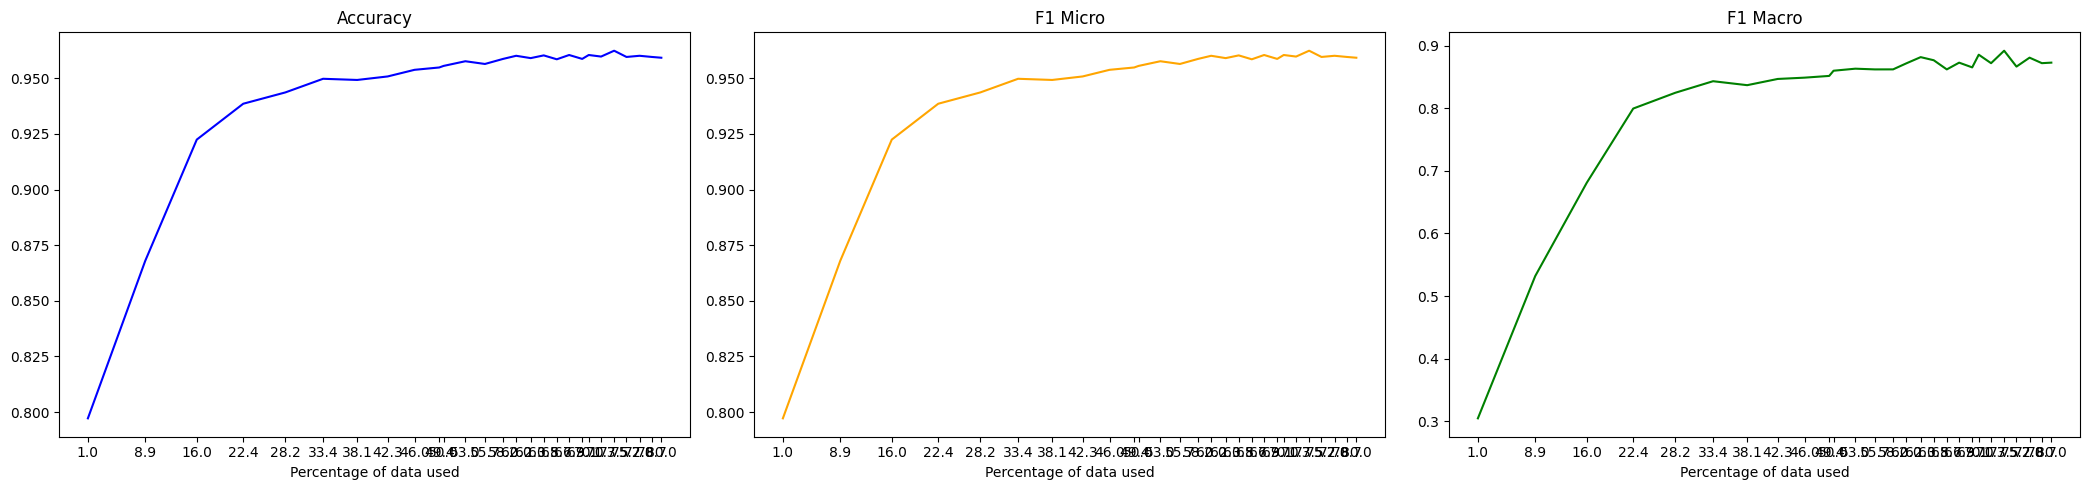

In [21]:
initial_train_size = int(0.01 * total_data)
active_learning(81, 0, 1)

Init Size 10
Random seed: 81
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6304, Accuracy: 0.8014, F1 Micro: 0.8897, F1 Macro: 0.8853
Epoch 2/10, Train Loss: 0.4839, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Epoch 3/10, Train Loss: 0.4418, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4257, Accuracy: 0.803, F1 Micro: 0.8905, F1 Macro: 0.8861
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4169, Accuracy: 0.8304, F1 Micro: 0.9037, F1 Macro: 0.8985
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3785, Accuracy: 0.8505, F1 Micro: 0.9137, F1 Macro: 0.9087
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3439, Accuracy: 0.8767, F1 Micro: 0.9277, F1 Macro: 0.9227
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3093, Accuracy: 0.8839, F1 Micro: 0.9316, F1 Macro: 0.9269
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.274, Accuracy: 0.9042, F1 Micro: 0.9423, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5629, Accuracy: 0.7088, F1 Micro: 0.7088, F1 Macro: 0.4148
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3944, Accuracy: 0.7804, F1 Micro: 0.7804, F1 Macro: 0.7113
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3384, Accuracy: 0.7995, F1 Micro: 0.7995, F1 Macro: 0.7497
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2906, Accuracy: 0.815, F1 Micro: 0.815, F1 Macro: 0.7518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.233, Accuracy: 0.815, F1 Micro: 0.815, F1 Macro: 0.7668
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2122, Accuracy: 0.815, F1 Micro: 0.815, F1 Macro: 0.7615
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1913, Accuracy: 0.8222, F1 Micro: 0.8222, F1 Macro: 0.7497
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1635, Accuracy: 0.8305, F1 Micro: 0.8305, F1 Macro: 0.7737
Epoch 9/10, Train Loss: 0.1457, Accuracy: 0.8103, F1 Micro: 0.8

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5664, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4682, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4478, Accuracy: 0.8155, F1 Micro: 0.8967, F1 Macro: 0.8926
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3958, Accuracy: 0.8602, F1 Micro: 0.9188, F1 Macro: 0.9133
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3406, Accuracy: 0.899, F1 Micro: 0.9395, F1 Macro: 0.9345
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2841, Accuracy: 0.9075, F1 Micro: 0.9444, F1 Macro: 0.9405
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2442, Accuracy: 0.9234, F1 Micro: 0.9535, F1 Macro: 0.9503
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2098, Accuracy: 0.9292, F1 Micro: 0.9568, F1 Macro: 0.9537
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5287, Accuracy: 0.718, F1 Micro: 0.718, F1 Macro: 0.4214
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3423, Accuracy: 0.8308, F1 Micro: 0.8308, F1 Macro: 0.7645
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2623, Accuracy: 0.8449, F1 Micro: 0.8449, F1 Macro: 0.8046
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2414, Accuracy: 0.861, F1 Micro: 0.861, F1 Macro: 0.8151
Epoch 5/10, Train Loss: 0.173, Accuracy: 0.8469, F1 Micro: 0.8469, F1 Macro: 0.7759
Epoch 6/10, Train Loss: 0.1552, Accuracy: 0.851, F1 Micro: 0.851, F1 Macro: 0.7853
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0995, Accuracy: 0.8711, F1 Micro: 0.8711, F1 Macro: 0.8232
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0838, Accuracy: 0.8771, F1 Micro: 0.8771, F1 Macro: 0.8329
Epoch 9/10, Train Loss: 0.0845, Accuracy: 0.8751, F1 Micro: 0.8751, F1 Macro: 0.8306
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5588, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4654, Accuracy: 0.8085, F1 Micro: 0.8911, F1 Macro: 0.8808
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4233, Accuracy: 0.8545, F1 Micro: 0.9154, F1 Macro: 0.9089
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3651, Accuracy: 0.8998, F1 Micro: 0.9396, F1 Macro: 0.934
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2941, Accuracy: 0.921, F1 Micro: 0.9521, F1 Macro: 0.9488
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2398, Accuracy: 0.9328, F1 Micro: 0.959, F1 Macro: 0.956
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2167, Accuracy: 0.9384, F1 Micro: 0.9624, F1 Macro: 0.9597
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1821, Accuracy: 0.9443, F1 Micro: 0.9658, F1 Macro: 0.9627
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5276, Accuracy: 0.82, F1 Micro: 0.82, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3146, Accuracy: 0.8252, F1 Micro: 0.8252, F1 Macro: 0.7298
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2625, Accuracy: 0.8528, F1 Micro: 0.8528, F1 Macro: 0.7847
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2134, Accuracy: 0.8814, F1 Micro: 0.8814, F1 Macro: 0.8466
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1685, Accuracy: 0.8957, F1 Micro: 0.8957, F1 Macro: 0.8637
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1142, Accuracy: 0.8967, F1 Micro: 0.8967, F1 Macro: 0.8648
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0875, Accuracy: 0.8988, F1 Micro: 0.8988, F1 Macro: 0.8675
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0733, Accuracy: 0.9008, F1 Micro: 0.9008, F1 Macro: 0.8663
Epoch 9/10, Train Loss: 0.0587, Accuracy: 0.8998, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5411, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4614, Accuracy: 0.8283, F1 Micro: 0.902, F1 Macro: 0.8952
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3924, Accuracy: 0.8934, F1 Micro: 0.9366, F1 Macro: 0.9316
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3134, Accuracy: 0.9177, F1 Micro: 0.9499, F1 Macro: 0.9449
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2444, Accuracy: 0.9361, F1 Micro: 0.961, F1 Macro: 0.9585
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2123, Accuracy: 0.9458, F1 Micro: 0.9668, F1 Macro: 0.9641
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1785, Accuracy: 0.9502, F1 Micro: 0.9693, F1 Macro: 0.9666
Epoch 8/10, Train Loss: 0.1572, Accuracy: 0.9497, F1 Micro: 0.9689, F1 Macro: 0.9658
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1397, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4697, Accuracy: 0.8417, F1 Micro: 0.8417, F1 Macro: 0.7961
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2763, Accuracy: 0.8745, F1 Micro: 0.8745, F1 Macro: 0.8327
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2388, Accuracy: 0.8803, F1 Micro: 0.8803, F1 Macro: 0.8366
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1916, Accuracy: 0.8929, F1 Micro: 0.8929, F1 Macro: 0.8547
Epoch 5/10, Train Loss: 0.1517, Accuracy: 0.89, F1 Micro: 0.89, F1 Macro: 0.8501
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1074, Accuracy: 0.9015, F1 Micro: 0.9015, F1 Macro: 0.8687
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0826, Accuracy: 0.9025, F1 Micro: 0.9025, F1 Macro: 0.8743
Epoch 8/10, Train Loss: 0.0861, Accuracy: 0.8958, F1 Micro: 0.8958, F1 Macro: 0.8614
Epoch 9/10, Train Loss: 0.0616, Accuracy: 0.8986, F1 Micro: 0.8986, F1 Macro: 0.8647
Epoch 10/10, Train Loss: 0.0496, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5309, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4493, Accuracy: 0.8455, F1 Micro: 0.9112, F1 Macro: 0.9059
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3648, Accuracy: 0.9099, F1 Micro: 0.9456, F1 Macro: 0.941
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2757, Accuracy: 0.9363, F1 Micro: 0.9609, F1 Macro: 0.9574
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2262, Accuracy: 0.9479, F1 Micro: 0.968, F1 Macro: 0.9654
Epoch 6/10, Train Loss: 0.1962, Accuracy: 0.945, F1 Micro: 0.9664, F1 Macro: 0.9638
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1696, Accuracy: 0.9561, F1 Micro: 0.9729, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1443, Accuracy: 0.9576, F1 Micro: 0.9738, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1198, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5025, Accuracy: 0.8319, F1 Micro: 0.8319, F1 Macro: 0.7591
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3233, Accuracy: 0.8609, F1 Micro: 0.8609, F1 Macro: 0.8158
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2546, Accuracy: 0.8758, F1 Micro: 0.8758, F1 Macro: 0.8318
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1863, Accuracy: 0.8786, F1 Micro: 0.8786, F1 Macro: 0.8336
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1568, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.8745
Epoch 6/10, Train Loss: 0.1304, Accuracy: 0.8945, F1 Micro: 0.8945, F1 Macro: 0.8654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1053, Accuracy: 0.9066, F1 Micro: 0.9066, F1 Macro: 0.881
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.079, Accuracy: 0.9076, F1 Micro: 0.9076, F1 Macro: 0.8796
Epoch 9/10, Train Loss: 0.0626, Accuracy: 0.8982, F1 Micro: 0.8982, F1 Macro: 0.8662
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5302, Accuracy: 0.8012, F1 Micro: 0.8896, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4418, Accuracy: 0.8667, F1 Micro: 0.9213, F1 Macro: 0.9135
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3371, Accuracy: 0.9155, F1 Micro: 0.9491, F1 Macro: 0.946
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2634, Accuracy: 0.9429, F1 Micro: 0.9648, F1 Macro: 0.9619
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.219, Accuracy: 0.9464, F1 Micro: 0.9672, F1 Macro: 0.9648
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1795, Accuracy: 0.9507, F1 Micro: 0.9697, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1593, Accuracy: 0.9542, F1 Micro: 0.9716, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1348, Accuracy: 0.9556, F1 Micro: 0.9725, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.443, Accuracy: 0.8566, F1 Micro: 0.8566, F1 Macro: 0.8039
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3018, Accuracy: 0.8699, F1 Micro: 0.8699, F1 Macro: 0.8266
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2382, Accuracy: 0.886, F1 Micro: 0.886, F1 Macro: 0.8527
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1888, Accuracy: 0.9022, F1 Micro: 0.9022, F1 Macro: 0.8731
Epoch 5/10, Train Loss: 0.1234, Accuracy: 0.8965, F1 Micro: 0.8965, F1 Macro: 0.8705
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0881, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.8829
Epoch 7/10, Train Loss: 0.0752, Accuracy: 0.9041, F1 Micro: 0.9041, F1 Macro: 0.8747
Epoch 8/10, Train Loss: 0.0615, Accuracy: 0.9022, F1 Micro: 0.9022, F1 Macro: 0.8725
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0457, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.8788
Epoch 10/10, Train Loss: 0.0391, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5274, Accuracy: 0.8148, F1 Micro: 0.8957, F1 Macro: 0.8898
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4204, Accuracy: 0.8835, F1 Micro: 0.9306, F1 Macro: 0.924
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3137, Accuracy: 0.9304, F1 Micro: 0.9577, F1 Macro: 0.9548
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.242, Accuracy: 0.9458, F1 Micro: 0.9667, F1 Macro: 0.9643
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1984, Accuracy: 0.9505, F1 Micro: 0.9695, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1692, Accuracy: 0.9545, F1 Micro: 0.972, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1456, Accuracy: 0.9573, F1 Micro: 0.9736, F1 Macro: 0.971
Epoch 8/10, Train Loss: 0.1231, Accuracy: 0.9568, F1 Micro: 0.9731, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1104, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.452, Accuracy: 0.8419, F1 Micro: 0.8419, F1 Macro: 0.7959
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3068, Accuracy: 0.8675, F1 Micro: 0.8675, F1 Macro: 0.8344
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2201, Accuracy: 0.8803, F1 Micro: 0.8803, F1 Macro: 0.8411
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1947, Accuracy: 0.8894, F1 Micro: 0.8894, F1 Macro: 0.8588
Epoch 5/10, Train Loss: 0.1295, Accuracy: 0.8867, F1 Micro: 0.8867, F1 Macro: 0.8522
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1051, Accuracy: 0.8967, F1 Micro: 0.8967, F1 Macro: 0.8682
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1, Accuracy: 0.8967, F1 Micro: 0.8967, F1 Macro: 0.8673
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0634, Accuracy: 0.8976, F1 Micro: 0.8976, F1 Macro: 0.8677
Epoch 9/10, Train Loss: 0.0514, Accuracy: 0.8949, F1 Micro: 0.8949, F1 Macro: 0.8655
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.52, Accuracy: 0.8095, F1 Micro: 0.8912, F1 Macro: 0.8791
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4066, Accuracy: 0.8983, F1 Micro: 0.9394, F1 Macro: 0.9343
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2922, Accuracy: 0.9306, F1 Micro: 0.9579, F1 Macro: 0.9549
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2244, Accuracy: 0.9453, F1 Micro: 0.9663, F1 Macro: 0.9638
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1906, Accuracy: 0.9535, F1 Micro: 0.9713, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1565, Accuracy: 0.9554, F1 Micro: 0.9724, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1317, Accuracy: 0.9578, F1 Micro: 0.974, F1 Macro: 0.9717
Epoch 8/10, Train Loss: 0.1183, Accuracy: 0.9559, F1 Micro: 0.9729, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1012, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4437, Accuracy: 0.8489, F1 Micro: 0.8489, F1 Macro: 0.7973
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2943, Accuracy: 0.881, F1 Micro: 0.881, F1 Macro: 0.845
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2205, Accuracy: 0.8874, F1 Micro: 0.8874, F1 Macro: 0.8485
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1572, Accuracy: 0.902, F1 Micro: 0.902, F1 Macro: 0.8734
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1152, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.8755
Epoch 6/10, Train Loss: 0.0846, Accuracy: 0.9029, F1 Micro: 0.9029, F1 Macro: 0.8767
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0644, Accuracy: 0.9066, F1 Micro: 0.9066, F1 Macro: 0.8811
Epoch 8/10, Train Loss: 0.0484, Accuracy: 0.9002, F1 Micro: 0.9002, F1 Macro: 0.8728
Epoch 9/10, Train Loss: 0.0326, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8774
Epoch 10/10, Train Loss: 0.039, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5161, Accuracy: 0.8182, F1 Micro: 0.8975, F1 Macro: 0.8919
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.396, Accuracy: 0.901, F1 Micro: 0.9409, F1 Macro: 0.9367
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2794, Accuracy: 0.9401, F1 Micro: 0.9634, F1 Macro: 0.9609
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2212, Accuracy: 0.9429, F1 Micro: 0.9652, F1 Macro: 0.9628
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1859, Accuracy: 0.9569, F1 Micro: 0.9734, F1 Macro: 0.9713
Epoch 6/10, Train Loss: 0.154, Accuracy: 0.9563, F1 Micro: 0.973, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1315, Accuracy: 0.9604, F1 Micro: 0.9754, F1 Macro: 0.973
Epoch 8/10, Train Loss: 0.1135, Accuracy: 0.9602, F1 Micro: 0.9753, F1 Macro: 0.9727
Epoch 9/10, Train Loss: 0.0962, Accuracy: 0.9597, F1 Micro: 0.975, F1 Macro: 0.9725
Higher F1 achieved, saving

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4288, Accuracy: 0.8575, F1 Micro: 0.8575, F1 Macro: 0.8143
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2748, Accuracy: 0.8796, F1 Micro: 0.8796, F1 Macro: 0.8389
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2009, Accuracy: 0.9044, F1 Micro: 0.9044, F1 Macro: 0.8741
Epoch 4/10, Train Loss: 0.1358, Accuracy: 0.8961, F1 Micro: 0.8961, F1 Macro: 0.863
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0978, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.8851
Epoch 6/10, Train Loss: 0.074, Accuracy: 0.9035, F1 Micro: 0.9035, F1 Macro: 0.8748
Epoch 7/10, Train Loss: 0.0632, Accuracy: 0.9081, F1 Micro: 0.9081, F1 Macro: 0.8801
Epoch 8/10, Train Loss: 0.0459, Accuracy: 0.898, F1 Micro: 0.898, F1 Macro: 0.8638
Epoch 9/10, Train Loss: 0.0285, Accuracy: 0.9017, F1 Micro: 0.9017, F1 Macro: 0.8721
Epoch 10/10, Train Loss: 0.0301, Accuracy: 0.9053, F1 Micro: 0.9053, F1 Macro: 0.878

Sentiment analysis ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5074, Accuracy: 0.8139, F1 Micro: 0.8951, F1 Macro: 0.8889
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3879, Accuracy: 0.904, F1 Micro: 0.9427, F1 Macro: 0.9385
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2745, Accuracy: 0.9394, F1 Micro: 0.9629, F1 Macro: 0.9602
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2173, Accuracy: 0.9502, F1 Micro: 0.9693, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1732, Accuracy: 0.9543, F1 Micro: 0.9718, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1504, Accuracy: 0.9594, F1 Micro: 0.9749, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1334, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9736
Epoch 8/10, Train Loss: 0.1068, Accuracy: 0.9604, F1 Micro: 0.9754, F1 Macro: 0.9729
Epoch 9/10, Train Loss: 0.0947, Accuracy: 0.9601, F1 Micro: 0.9752, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4135, Accuracy: 0.857, F1 Micro: 0.857, F1 Macro: 0.8117
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2595, Accuracy: 0.8634, F1 Micro: 0.8634, F1 Macro: 0.815
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1841, Accuracy: 0.8992, F1 Micro: 0.8992, F1 Macro: 0.8711
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1467, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.882
Epoch 5/10, Train Loss: 0.088, Accuracy: 0.8882, F1 Micro: 0.8882, F1 Macro: 0.8545
Epoch 6/10, Train Loss: 0.0874, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.8771
Epoch 7/10, Train Loss: 0.0585, Accuracy: 0.9001, F1 Micro: 0.9001, F1 Macro: 0.8754
Epoch 8/10, Train Loss: 0.0508, Accuracy: 0.8946, F1 Micro: 0.8946, F1 Macro: 0.8663
Epoch 9/10, Train Loss: 0.0306, Accuracy: 0.9047, F1 Micro: 0.9047, F1 Macro: 0.8784
Epoch 10/10, Train Loss: 0.035, Accuracy: 0.8992, F1 Micro: 0.8992, F1 Macro: 0.8703

Sentiment analysis acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5069, Accuracy: 0.8266, F1 Micro: 0.9007, F1 Macro: 0.8929
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3771, Accuracy: 0.9075, F1 Micro: 0.9448, F1 Macro: 0.9415
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2605, Accuracy: 0.9401, F1 Micro: 0.9634, F1 Macro: 0.9611
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2107, Accuracy: 0.9535, F1 Micro: 0.9714, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1708, Accuracy: 0.9547, F1 Micro: 0.972, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1372, Accuracy: 0.9563, F1 Micro: 0.9729, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1244, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1032, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9746
Epoch 9/10, Train Loss: 0.09, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4265, Accuracy: 0.8342, F1 Micro: 0.8342, F1 Macro: 0.7652
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2848, Accuracy: 0.8808, F1 Micro: 0.8808, F1 Macro: 0.8463
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1989, Accuracy: 0.8943, F1 Micro: 0.8943, F1 Macro: 0.8635
Epoch 4/10, Train Loss: 0.1381, Accuracy: 0.8916, F1 Micro: 0.8916, F1 Macro: 0.8586
Epoch 5/10, Train Loss: 0.0956, Accuracy: 0.8934, F1 Micro: 0.8934, F1 Macro: 0.8612
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0935, Accuracy: 0.8978, F1 Micro: 0.8978, F1 Macro: 0.8678
Epoch 7/10, Train Loss: 0.0489, Accuracy: 0.897, F1 Micro: 0.897, F1 Macro: 0.8682
Epoch 8/10, Train Loss: 0.058, Accuracy: 0.897, F1 Micro: 0.897, F1 Macro: 0.8656
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.8978, F1 Micro: 0.8978, F1 Macro: 0.8698
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0367, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4986, Accuracy: 0.8127, F1 Micro: 0.895, F1 Macro: 0.89
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3652, Accuracy: 0.9134, F1 Micro: 0.9477, F1 Macro: 0.9434
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2565, Accuracy: 0.9462, F1 Micro: 0.967, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2039, Accuracy: 0.9491, F1 Micro: 0.9688, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.166, Accuracy: 0.9578, F1 Micro: 0.9739, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1442, Accuracy: 0.9578, F1 Micro: 0.9739, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1189, Accuracy: 0.9622, F1 Micro: 0.9766, F1 Macro: 0.9747
Epoch 8/10, Train Loss: 0.1026, Accuracy: 0.9618, F1 Micro: 0.9764, F1 Macro: 0.9743
Epoch 9/10, Train Loss: 0.0861, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4026, Accuracy: 0.8524, F1 Micro: 0.8524, F1 Macro: 0.797
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2463, Accuracy: 0.8973, F1 Micro: 0.8973, F1 Macro: 0.8682
Epoch 3/10, Train Loss: 0.1861, Accuracy: 0.8854, F1 Micro: 0.8854, F1 Macro: 0.8448
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.126, Accuracy: 0.9056, F1 Micro: 0.9056, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0934, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.8881
Epoch 6/10, Train Loss: 0.0717, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.8805
Epoch 7/10, Train Loss: 0.0453, Accuracy: 0.9001, F1 Micro: 0.9001, F1 Macro: 0.8692
Epoch 8/10, Train Loss: 0.0521, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.8865
Epoch 9/10, Train Loss: 0.023, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.8852
Epoch 10/10, Train Loss: 0.0231, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8844

Sentiment analysis ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.495, Accuracy: 0.8172, F1 Micro: 0.8974, F1 Macro: 0.8928
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3575, Accuracy: 0.9156, F1 Micro: 0.9491, F1 Macro: 0.9452
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2508, Accuracy: 0.9481, F1 Micro: 0.9682, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2001, Accuracy: 0.9497, F1 Micro: 0.9691, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1625, Accuracy: 0.9556, F1 Micro: 0.9726, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1384, Accuracy: 0.9585, F1 Micro: 0.9744, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1157, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0997, Accuracy: 0.962, F1 Micro: 0.9765, F1 Macro: 0.9742
Epoch 9/10, Train Loss: 0.0895, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4047, Accuracy: 0.8633, F1 Micro: 0.8633, F1 Macro: 0.8272
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2426, Accuracy: 0.8788, F1 Micro: 0.8788, F1 Macro: 0.8529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1741, Accuracy: 0.9043, F1 Micro: 0.9043, F1 Macro: 0.8776
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1223, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.8825
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0962, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8815
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0673, Accuracy: 0.9107, F1 Micro: 0.9107, F1 Macro: 0.8852
Epoch 7/10, Train Loss: 0.056, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8804
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0399, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.8873
Epoch 9/10, Train Loss: 0.0257, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8826
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4949, Accuracy: 0.8356, F1 Micro: 0.906, F1 Macro: 0.9012
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3392, Accuracy: 0.9208, F1 Micro: 0.9523, F1 Macro: 0.9488
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2364, Accuracy: 0.9431, F1 Micro: 0.9652, F1 Macro: 0.9629
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1843, Accuracy: 0.9556, F1 Micro: 0.9726, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1503, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.9732
Epoch 6/10, Train Loss: 0.1279, Accuracy: 0.9585, F1 Micro: 0.9743, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1093, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0928, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 0.9749
Epoch 9/10, Train Loss: 0.0815, Accuracy: 0.9615, F1 Micro: 0.9762, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3933, Accuracy: 0.8672, F1 Micro: 0.8672, F1 Macro: 0.8188
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2577, Accuracy: 0.9011, F1 Micro: 0.9011, F1 Macro: 0.8731
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1647, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.8833
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.132, Accuracy: 0.9153, F1 Micro: 0.9153, F1 Macro: 0.8896
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0833, Accuracy: 0.9171, F1 Micro: 0.9171, F1 Macro: 0.8913
Epoch 6/10, Train Loss: 0.0484, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.8833
Epoch 7/10, Train Loss: 0.0465, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.8869
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0438, Accuracy: 0.919, F1 Micro: 0.919, F1 Macro: 0.8911
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.038, Accuracy: 0.919, F1 Micro: 0.919, F1 Macro: 0.8922
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4944, Accuracy: 0.8406, F1 Micro: 0.9075, F1 Macro: 0.8994
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3394, Accuracy: 0.9302, F1 Micro: 0.9574, F1 Macro: 0.9539
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2337, Accuracy: 0.9443, F1 Micro: 0.9657, F1 Macro: 0.9628
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1835, Accuracy: 0.9486, F1 Micro: 0.9686, F1 Macro: 0.9663
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1512, Accuracy: 0.9583, F1 Micro: 0.9743, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1291, Accuracy: 0.9609, F1 Micro: 0.9759, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1096, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.093, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9758
Epoch 9/10, Train Loss: 0.0786, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3796, Accuracy: 0.8702, F1 Micro: 0.8702, F1 Macro: 0.8282
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2142, Accuracy: 0.8838, F1 Micro: 0.8838, F1 Macro: 0.8468
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1659, Accuracy: 0.902, F1 Micro: 0.902, F1 Macro: 0.8734
Epoch 4/10, Train Loss: 0.1237, Accuracy: 0.8966, F1 Micro: 0.8966, F1 Macro: 0.8635
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0966, Accuracy: 0.9056, F1 Micro: 0.9056, F1 Macro: 0.8783
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0538, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.8843
Epoch 7/10, Train Loss: 0.0499, Accuracy: 0.9029, F1 Micro: 0.9029, F1 Macro: 0.8724
Epoch 8/10, Train Loss: 0.0553, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8817
Epoch 9/10, Train Loss: 0.0461, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8825
Epoch 10/10, Train Loss: 0.0279, Accuracy: 0.9093, F1 Micro: 0.9093, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.488, Accuracy: 0.8457, F1 Micro: 0.9104, F1 Macro: 0.9036
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3264, Accuracy: 0.9262, F1 Micro: 0.9552, F1 Macro: 0.9524
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2336, Accuracy: 0.9441, F1 Micro: 0.9659, F1 Macro: 0.9634
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1868, Accuracy: 0.9512, F1 Micro: 0.97, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1517, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1227, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9744
Epoch 7/10, Train Loss: 0.1076, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0921, Accuracy: 0.9663, F1 Micro: 0.9791, F1 Macro: 0.9768
Epoch 9/10, Train Loss: 0.0752, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3928, Accuracy: 0.8411, F1 Micro: 0.8411, F1 Macro: 0.8132
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2315, Accuracy: 0.905, F1 Micro: 0.905, F1 Macro: 0.878
Epoch 3/10, Train Loss: 0.1678, Accuracy: 0.8959, F1 Micro: 0.8959, F1 Macro: 0.872
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.103, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.8878
Epoch 5/10, Train Loss: 0.0826, Accuracy: 0.9123, F1 Micro: 0.9123, F1 Macro: 0.8894
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0536, Accuracy: 0.9178, F1 Micro: 0.9178, F1 Macro: 0.8958
Epoch 7/10, Train Loss: 0.0607, Accuracy: 0.9169, F1 Micro: 0.9169, F1 Macro: 0.895
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0439, Accuracy: 0.9196, F1 Micro: 0.9196, F1 Macro: 0.8963
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0343, Accuracy: 0.9224, F1 Micro: 0.9224, F1 Macro: 0.9007
Epoch 10/10, Train Loss: 0.0216, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4826, Accuracy: 0.8533, F1 Micro: 0.9151, F1 Macro: 0.9101
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3173, Accuracy: 0.9319, F1 Micro: 0.9585, F1 Macro: 0.9555
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2192, Accuracy: 0.9464, F1 Micro: 0.9671, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1696, Accuracy: 0.9542, F1 Micro: 0.9717, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1485, Accuracy: 0.9576, F1 Micro: 0.9739, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.125, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9749
Epoch 7/10, Train Loss: 0.1016, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0864, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9752
Epoch 9/10, Train Loss: 0.0713, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3806, Accuracy: 0.8537, F1 Micro: 0.8537, F1 Macro: 0.7944
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2109, Accuracy: 0.9025, F1 Micro: 0.9025, F1 Macro: 0.8734
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1478, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.8821
Epoch 4/10, Train Loss: 0.1123, Accuracy: 0.9071, F1 Micro: 0.9071, F1 Macro: 0.8803
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0691, Accuracy: 0.9181, F1 Micro: 0.9181, F1 Macro: 0.8943
Epoch 6/10, Train Loss: 0.0617, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.8883
Epoch 7/10, Train Loss: 0.0532, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.8928
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0376, Accuracy: 0.9181, F1 Micro: 0.9181, F1 Macro: 0.8938
Epoch 9/10, Train Loss: 0.0291, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.8818
Epoch 10/10, Train Loss: 0.0243, Accuracy: 0.9126, F1 Micro: 0.9126, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4854, Accuracy: 0.8582, F1 Micro: 0.9168, F1 Macro: 0.9098
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3054, Accuracy: 0.9354, F1 Micro: 0.9607, F1 Macro: 0.9583
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2195, Accuracy: 0.9488, F1 Micro: 0.9685, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.175, Accuracy: 0.9552, F1 Micro: 0.9724, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1415, Accuracy: 0.9592, F1 Micro: 0.9748, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1254, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0995, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0833, Accuracy: 0.9656, F1 Micro: 0.9787, F1 Macro: 0.9768
Epoch 9/10, Train Loss: 0.0705, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3656, Accuracy: 0.8843, F1 Micro: 0.8843, F1 Macro: 0.8486
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2114, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.8806
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1402, Accuracy: 0.9137, F1 Micro: 0.9137, F1 Macro: 0.8883
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1112, Accuracy: 0.9183, F1 Micro: 0.9183, F1 Macro: 0.8934
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.082, Accuracy: 0.9201, F1 Micro: 0.9201, F1 Macro: 0.8963
Epoch 6/10, Train Loss: 0.0737, Accuracy: 0.9183, F1 Micro: 0.9183, F1 Macro: 0.8951
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0618, Accuracy: 0.9219, F1 Micro: 0.9219, F1 Macro: 0.8989
Epoch 8/10, Train Loss: 0.0564, Accuracy: 0.9137, F1 Micro: 0.9137, F1 Macro: 0.8881
Epoch 9/10, Train Loss: 0.0329, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.8848
Epoch 10/10, Train Loss: 0.0319, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4793, Accuracy: 0.8472, F1 Micro: 0.912, F1 Macro: 0.9069
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3115, Accuracy: 0.9318, F1 Micro: 0.9586, F1 Macro: 0.9561
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2105, Accuracy: 0.9516, F1 Micro: 0.9702, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1667, Accuracy: 0.9576, F1 Micro: 0.9738, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1381, Accuracy: 0.9587, F1 Micro: 0.9745, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1141, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0976, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9751
Epoch 8/10, Train Loss: 0.0821, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.9736
Epoch 9/10, Train Loss: 0.0707, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3648, Accuracy: 0.8466, F1 Micro: 0.8466, F1 Macro: 0.812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2006, Accuracy: 0.9002, F1 Micro: 0.9002, F1 Macro: 0.8717
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1542, Accuracy: 0.9057, F1 Micro: 0.9057, F1 Macro: 0.8799
Epoch 4/10, Train Loss: 0.1005, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8801
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.07, Accuracy: 0.9067, F1 Micro: 0.9067, F1 Macro: 0.8776
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0547, Accuracy: 0.9168, F1 Micro: 0.9168, F1 Macro: 0.8928
Epoch 7/10, Train Loss: 0.0625, Accuracy: 0.914, F1 Micro: 0.914, F1 Macro: 0.8896
Epoch 8/10, Train Loss: 0.0331, Accuracy: 0.9131, F1 Micro: 0.9131, F1 Macro: 0.8888
Epoch 9/10, Train Loss: 0.0298, Accuracy: 0.9159, F1 Micro: 0.9159, F1 Macro: 0.891
Epoch 10/10, Train Loss: 0.0374, Accuracy: 0.9085, F1 Micro: 0.9085, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4815, Accuracy: 0.8656, F1 Micro: 0.9214, F1 Macro: 0.9156
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3045, Accuracy: 0.9344, F1 Micro: 0.96, F1 Macro: 0.9575
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2065, Accuracy: 0.9481, F1 Micro: 0.9682, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1717, Accuracy: 0.9552, F1 Micro: 0.9724, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1387, Accuracy: 0.9592, F1 Micro: 0.9748, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1164, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9752
Epoch 7/10, Train Loss: 0.0976, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0806, Accuracy: 0.9655, F1 Micro: 0.9786, F1 Macro: 0.9766
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.067, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3768, Accuracy: 0.8597, F1 Micro: 0.8597, F1 Macro: 0.8208
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2255, Accuracy: 0.8998, F1 Micro: 0.8998, F1 Macro: 0.8694
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1371, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8784
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1005, Accuracy: 0.9107, F1 Micro: 0.9107, F1 Macro: 0.8859
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0827, Accuracy: 0.9107, F1 Micro: 0.9107, F1 Macro: 0.8811
Epoch 6/10, Train Loss: 0.0693, Accuracy: 0.9071, F1 Micro: 0.9071, F1 Macro: 0.8797
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0605, Accuracy: 0.9162, F1 Micro: 0.9162, F1 Macro: 0.8895
Epoch 8/10, Train Loss: 0.0364, Accuracy: 0.9135, F1 Micro: 0.9135, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.038, Accuracy: 0.9171, F1 Micro: 0.9171, F1 Macro: 0.8906
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4735, Accuracy: 0.8712, F1 Micro: 0.9244, F1 Macro: 0.9188
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2994, Accuracy: 0.9349, F1 Micro: 0.9603, F1 Macro: 0.9581
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2111, Accuracy: 0.9458, F1 Micro: 0.9669, F1 Macro: 0.9646
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1626, Accuracy: 0.9561, F1 Micro: 0.9729, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1328, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1146, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0978, Accuracy: 0.9655, F1 Micro: 0.9786, F1 Macro: 0.9768
Epoch 8/10, Train Loss: 0.0793, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9742
Epoch 9/10, Train Loss: 0.0684, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3604, Accuracy: 0.8661, F1 Micro: 0.8661, F1 Macro: 0.8143
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2133, Accuracy: 0.8984, F1 Micro: 0.8984, F1 Macro: 0.8656
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1469, Accuracy: 0.9123, F1 Micro: 0.9123, F1 Macro: 0.8844
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1134, Accuracy: 0.9197, F1 Micro: 0.9197, F1 Macro: 0.8949
Epoch 5/10, Train Loss: 0.0965, Accuracy: 0.9178, F1 Micro: 0.9178, F1 Macro: 0.8927
Epoch 6/10, Train Loss: 0.0588, Accuracy: 0.9141, F1 Micro: 0.9141, F1 Macro: 0.8884
Epoch 7/10, Train Loss: 0.0453, Accuracy: 0.9123, F1 Micro: 0.9123, F1 Macro: 0.8821
Epoch 8/10, Train Loss: 0.0333, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.8862
Epoch 9/10, Train Loss: 0.0222, Accuracy: 0.916, F1 Micro: 0.916, F1 Macro: 0.8873
Epoch 10/10, Train Loss: 0.0268, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.8871

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4711, Accuracy: 0.8738, F1 Micro: 0.9259, F1 Macro: 0.921
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2886, Accuracy: 0.9352, F1 Micro: 0.9605, F1 Macro: 0.9578
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1983, Accuracy: 0.9497, F1 Micro: 0.9691, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1626, Accuracy: 0.9578, F1 Micro: 0.9739, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1331, Accuracy: 0.9592, F1 Micro: 0.9747, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1099, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0896, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macro: 0.9764
Epoch 8/10, Train Loss: 0.0763, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9743
Epoch 9/10, Train Loss: 0.0677, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3535, Accuracy: 0.8674, F1 Micro: 0.8674, F1 Macro: 0.8254
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2056, Accuracy: 0.8981, F1 Micro: 0.8981, F1 Macro: 0.8697
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.165, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8786
Epoch 4/10, Train Loss: 0.1077, Accuracy: 0.9035, F1 Micro: 0.9035, F1 Macro: 0.8771
Epoch 5/10, Train Loss: 0.0679, Accuracy: 0.9053, F1 Micro: 0.9053, F1 Macro: 0.8781
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0724, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.8835
Epoch 7/10, Train Loss: 0.0491, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8812
Epoch 8/10, Train Loss: 0.036, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8787
Epoch 9/10, Train Loss: 0.0291, Accuracy: 0.9026, F1 Micro: 0.9026, F1 Macro: 0.8739
Epoch 10/10, Train Loss: 0.0334, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8809

Sentiment analysis accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4638, Accuracy: 0.8778, F1 Micro: 0.9282, F1 Macro: 0.923
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2754, Accuracy: 0.9418, F1 Micro: 0.9644, F1 Macro: 0.9621
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2, Accuracy: 0.9521, F1 Micro: 0.9706, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1592, Accuracy: 0.9568, F1 Micro: 0.9734, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1295, Accuracy: 0.9611, F1 Micro: 0.976, F1 Macro: 0.9741
Epoch 6/10, Train Loss: 0.106, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0905, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0751, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.063, Accuracy: 0.96

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3562, Accuracy: 0.8718, F1 Micro: 0.8718, F1 Macro: 0.8252
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1885, Accuracy: 0.902, F1 Micro: 0.902, F1 Macro: 0.8734
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1294, Accuracy: 0.9057, F1 Micro: 0.9057, F1 Macro: 0.88
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0949, Accuracy: 0.9185, F1 Micro: 0.9185, F1 Macro: 0.8952
Epoch 5/10, Train Loss: 0.069, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.8935
Epoch 6/10, Train Loss: 0.0565, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.8921
Epoch 7/10, Train Loss: 0.04, Accuracy: 0.9148, F1 Micro: 0.9148, F1 Macro: 0.8905
Epoch 8/10, Train Loss: 0.0279, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.8874
Epoch 9/10, Train Loss: 0.0294, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.8931
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0161, Accuracy: 0.9203, F1 Micro: 0.9203, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4646, Accuracy: 0.8793, F1 Micro: 0.9286, F1 Macro: 0.9219
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2775, Accuracy: 0.9335, F1 Micro: 0.9595, F1 Macro: 0.9572
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1918, Accuracy: 0.9507, F1 Micro: 0.9697, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.156, Accuracy: 0.9561, F1 Micro: 0.973, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1294, Accuracy: 0.9618, F1 Micro: 0.9764, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1049, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0854, Accuracy: 0.9658, F1 Micro: 0.9788, F1 Macro: 0.9768
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0751, Accuracy: 0.9663, F1 Micro: 0.9791, F1 Macro: 0.9769
Epoch 9/10, Train Loss: 0.0639, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3358, Accuracy: 0.8527, F1 Micro: 0.8527, F1 Macro: 0.7926
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1848, Accuracy: 0.8976, F1 Micro: 0.8976, F1 Macro: 0.8662
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1303, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8764
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0901, Accuracy: 0.9075, F1 Micro: 0.9075, F1 Macro: 0.8833
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0608, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.886
Epoch 6/10, Train Loss: 0.0544, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.8824
Epoch 7/10, Train Loss: 0.0386, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.8832
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0324, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.8865
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0418, Accuracy: 0.9164, F1 Micro: 0.9164, F1 Macro: 0.8922
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.445, Accuracy: 0.8873, F1 Micro: 0.9331, F1 Macro: 0.9278
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2576, Accuracy: 0.941, F1 Micro: 0.964, F1 Macro: 0.9618
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1859, Accuracy: 0.9516, F1 Micro: 0.9702, F1 Macro: 0.9683
Epoch 4/10, Train Loss: 0.1478, Accuracy: 0.9503, F1 Micro: 0.9697, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1223, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0998, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0829, Accuracy: 0.9667, F1 Micro: 0.9793, F1 Macro: 0.9771
Epoch 8/10, Train Loss: 0.07, Accuracy: 0.9646, F1 Micro: 0.9781, F1 Macro: 0.976
Epoch 9/10, Train Loss: 0.0597, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9757
Epoch 10/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3397, Accuracy: 0.8756, F1 Micro: 0.8756, F1 Macro: 0.8383
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1882, Accuracy: 0.9085, F1 Micro: 0.9085, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1232, Accuracy: 0.9158, F1 Micro: 0.9158, F1 Macro: 0.8918
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0845, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.8911
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.064, Accuracy: 0.9195, F1 Micro: 0.9195, F1 Macro: 0.8953
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0572, Accuracy: 0.9222, F1 Micro: 0.9222, F1 Macro: 0.8995
Epoch 7/10, Train Loss: 0.0476, Accuracy: 0.9186, F1 Micro: 0.9186, F1 Macro: 0.8933
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0421, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9001
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0343, Accuracy: 0.9305, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4528, Accuracy: 0.8826, F1 Micro: 0.9299, F1 Macro: 0.9228
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2642, Accuracy: 0.9415, F1 Micro: 0.9643, F1 Macro: 0.9621
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1879, Accuracy: 0.9512, F1 Micro: 0.9701, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1484, Accuracy: 0.9578, F1 Micro: 0.9739, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1199, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.101, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0834, Accuracy: 0.9642, F1 Micro: 0.9779, F1 Macro: 0.9758
Epoch 8/10, Train Loss: 0.0697, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9755
Epoch 9/10, Train Loss: 0.0587, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3563, Accuracy: 0.8818, F1 Micro: 0.8818, F1 Macro: 0.8403
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1863, Accuracy: 0.8957, F1 Micro: 0.8957, F1 Macro: 0.8564
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1301, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.8829
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1052, Accuracy: 0.9181, F1 Micro: 0.9181, F1 Macro: 0.8914
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0556, Accuracy: 0.9181, F1 Micro: 0.9181, F1 Macro: 0.8909
Epoch 6/10, Train Loss: 0.0528, Accuracy: 0.9143, F1 Micro: 0.9143, F1 Macro: 0.8865
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0471, Accuracy: 0.9181, F1 Micro: 0.9181, F1 Macro: 0.8884
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0357, Accuracy: 0.9199, F1 Micro: 0.9199, F1 Macro: 0.8928
Epoch 9/10, Train Loss: 0.0471, Accuracy: 0.919, F1 Micro: 0.919, F1 Macro: 0.8915
Epoch 

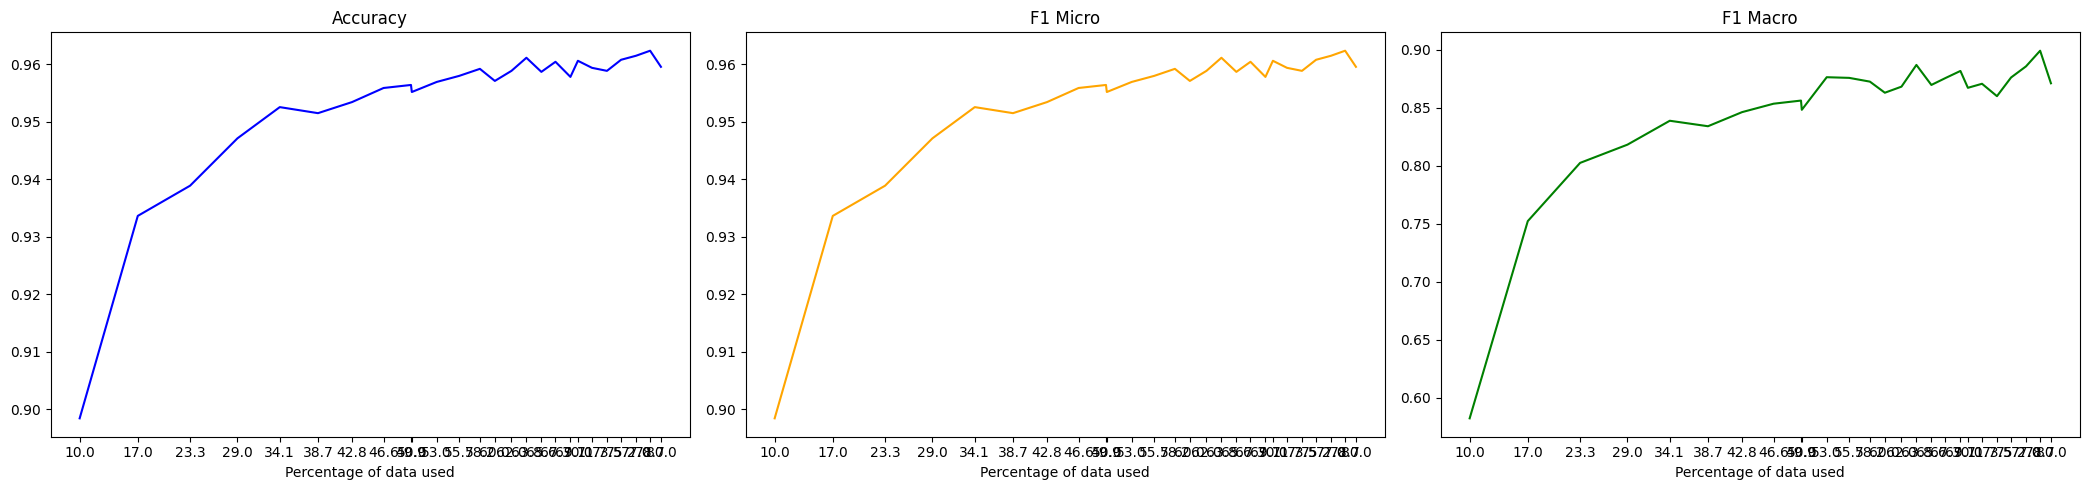

In [22]:
initial_train_size = int(0.1 * total_data)
active_learning(81, 0, 10)